In [2623]:
import pandas as pd
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
import re
import datetime
import math

In [2624]:
print(pd.show_versions())


INSTALLED VERSIONS
------------------
commit              : 2a953cf80b77e4348bf50ed724f8abc0d814d9dd
python              : 3.10.10.final.0
python-bits         : 64
OS                  : Darwin
OS-release          : 22.3.0
Version             : Darwin Kernel Version 22.3.0: Mon Jan 30 20:42:11 PST 2023; root:xnu-8792.81.3~2/RELEASE_X86_64
machine             : x86_64
processor           : i386
byteorder           : little
LC_ALL              : None
LANG                : en_US.UTF-8
LOCALE              : en_US.UTF-8

pandas              : 2.1.3
numpy               : 1.26.2
pytz                : 2023.3.post1
dateutil            : 2.8.2
setuptools          : 67.2.0
pip                 : 23.3.1
Cython              : None
pytest              : None
hypothesis          : None
sphinx              : None
blosc               : None
feather             : None
xlsxwriter          : None
lxml.etree          : None
html5lib            : None
pymysql             : None
psycopg2            : None
jin

In [2625]:
df = pd.read_csv("./marketing_data.csv")
df.sample(10)
print(df.shape)
print(df.dtypes)
# df.describe
# df.info()

(2240, 28)
ID                      int64
Year_Birth              int64
Education              object
Marital_Status         object
 Income                object
Kidhome                 int64
Teenhome                int64
Dt_Customer            object
Recency                 int64
MntWines                int64
MntFruits               int64
MntMeatProducts         int64
MntFishProducts         int64
MntSweetProducts        int64
MntGoldProds            int64
NumDealsPurchases       int64
NumWebPurchases         int64
NumCatalogPurchases     int64
NumStorePurchases       int64
NumWebVisitsMonth       int64
AcceptedCmp3            int64
AcceptedCmp4            int64
AcceptedCmp5            int64
AcceptedCmp1            int64
AcceptedCmp2            int64
Response                int64
Complain                int64
Country                object
dtype: object


# Data Wrangling


## Column Name Cleanup


In [2626]:
# Clean up column names
df.rename(
    {
        " Income ": "Income",
        "Year_Birth": "YearBirth",
        "Marital_Status": "MaritalStatus",
        "Dt_Customer": "DtCustomer",
    },
    axis=1,
    inplace=True,
)
df.columns

Index(['ID', 'YearBirth', 'Education', 'MaritalStatus', 'Income', 'Kidhome',
       'Teenhome', 'DtCustomer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Response', 'Complain', 'Country'],
      dtype='object')

In [2627]:
# Income
# Strip of unwanted chars
# df['Income']
unwanted_chars = r"(\,)|(\$)"
df["Income"] = df["Income"].str.replace(unwanted_chars, "", regex=True)

# Convert to Int or Float
zeros = r"(\.00)"
can_be_int = len(df["Income"].str.findall(zeros)) == len(df["Income"])

if can_be_int:
    df["Income"] = pd.to_numeric(df["Income"]).astype("Int64")
else:
    df["Income"] = pd.to_numeric(df["Income"]).astype("Float64")

df["Income"]

0       84835
1       57091
2       67267
3       32474
4       21474
        ...  
2235    66476
2236    31056
2237    46310
2238    65819
2239    94871
Name: Income, Length: 2240, dtype: Int64

In [2628]:
# DtCustomer - convert to date
df["DtCustomer"] = pd.to_datetime(df["DtCustomer"])
df.dtypes

/var/folders/cz/9yq4nxkn2wq92xfr_4fymfv00000gn/T/ipykernel_91925/2998029773.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["DtCustomer"] = pd.to_datetime(df["DtCustomer"])


ID                              int64
YearBirth                       int64
Education                      object
MaritalStatus                  object
Income                          Int64
Kidhome                         int64
Teenhome                        int64
DtCustomer             datetime64[ns]
Recency                         int64
MntWines                        int64
MntFruits                       int64
MntMeatProducts                 int64
MntFishProducts                 int64
MntSweetProducts                int64
MntGoldProds                    int64
NumDealsPurchases               int64
NumWebPurchases                 int64
NumCatalogPurchases             int64
NumStorePurchases               int64
NumWebVisitsMonth               int64
AcceptedCmp3                    int64
AcceptedCmp4                    int64
AcceptedCmp5                    int64
AcceptedCmp1                    int64
AcceptedCmp2                    int64
Response                        int64
Complain    

## Null Values


In [2629]:
df.isnull().sum()

ID                      0
YearBirth               0
Education               0
MaritalStatus           0
Income                 24
Kidhome                 0
Teenhome                0
DtCustomer              0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Response                0
Complain                0
Country                 0
dtype: int64

### Income Imputation

Find null Income values and replace with the average income for relationship status and level of education


In [2630]:
# MaritalStatus - grouping
df["MaritalStatus"].unique()

df["RelationshipStatus"] = np.where(
    df["MaritalStatus"].isin(["Married", "Together"]),
    "Coupled",
    np.where(
        df["MaritalStatus"].isin(["Single", "YOLO", "Alone", "Absurd"]),
        "NotCoupled",
        "BeenCoupled",
    ),
)
# df.sample(20)
# df['RelationshipStatus'].isnull().sum()
df["RelationshipStatus"].unique()

array(['BeenCoupled', 'NotCoupled', 'Coupled'], dtype=object)

In [2631]:
avg_income_by_rel_and_edu = df.pivot_table(
    values="Income", index=["Education"], columns=["RelationshipStatus"]
).astype("Int64")

print(avg_income_by_rel_and_edu)

been_coupled = avg_income_by_rel_and_edu["BeenCoupled"]
coupled = avg_income_by_rel_and_edu["Coupled"]
not_coupled = avg_income_by_rel_and_edu["NotCoupled"]


# BeenCoupled
been_coupled_2n = been_coupled["2n Cycle"]
been_coupled_basic = been_coupled["Basic"]
been_coupled_graduation = been_coupled["Graduation"]
been_coupled_master = been_coupled["Master"]
been_coupled_phd = been_coupled["PhD"]

# Coupled
coupled_2n = coupled["2n Cycle"]
coupled_basic = coupled["Basic"]
coupled_graduation = coupled["Graduation"]
coupled_master = coupled["Master"]
coupled_phd = coupled["PhD"]

# NotCoupled
not_coupled_2n = not_coupled["2n Cycle"]
not_coupled_basic = not_coupled["Basic"]
not_coupled_graduation = not_coupled["Graduation"]
not_coupled_master = not_coupled["Master"]
not_coupled_phd = not_coupled["PhD"]

RelationshipStatus  BeenCoupled  Coupled  NotCoupled
Education                                           
2n Cycle                  49751    45597       53673
Basic                     15835    21663       18238
Graduation                54628    52779       51365
Master                    52181    52785       53787
PhD                       55367    57343       53039


In [2632]:
is_been_coupled = df["RelationshipStatus"] == "BeenCoupled"
is_coupled = df["RelationshipStatus"] == "Coupled"
is_not_coupled = df["RelationshipStatus"] == "NotCoupled"

is_2n = df["Education"] == "2n Cycle"
is_basic = df["Education"] == "Basic"
is_graduation = df["Education"] == "Graduation"
is_master = df["Education"] == "Master"
is_phd = df["Education"] == "PhD"

nulls_before = df["Income"].isnull().sum()

if nulls_before > 0:
    print(f"Number of null values found: {nulls_before}")

    # BeenCoupled
    filter_been_coupled_2n = is_been_coupled & is_2n
    filter_been_coupled_basic = is_been_coupled & is_basic
    filter_been_coupled_graduation = is_been_coupled & is_graduation
    filter_been_coupled_master = is_been_coupled & is_master
    filter_been_coupled_phd = is_been_coupled & is_phd

    df.loc[filter_been_coupled_2n, "Income"] = df.loc[
        filter_been_coupled_2n, "Income"
    ].fillna(been_coupled_2n)
    df.loc[filter_been_coupled_basic, "Income"] = df.loc[
        filter_been_coupled_basic, "Income"
    ].fillna(been_coupled_basic)
    df.loc[filter_been_coupled_graduation, "Income"] = df.loc[
        filter_been_coupled_graduation, "Income"
    ].fillna(been_coupled_graduation)
    df.loc[filter_been_coupled_master, "Income"] = df.loc[
        filter_been_coupled_master, "Income"
    ].fillna(been_coupled_master)
    df.loc[filter_been_coupled_phd, "Income"] = df.loc[
        filter_been_coupled_phd, "Income"
    ].fillna(been_coupled_phd)

    # Coupled
    filter_coupled_2n = is_coupled & is_2n
    filter_coupled_basic = is_coupled & is_basic
    filter_coupled_graduation = is_coupled & is_graduation
    filter_coupled_master = is_coupled & is_master
    filter_coupled_phd = is_coupled & is_phd

    df.loc[filter_coupled_2n, "Income"] = df.loc[filter_coupled_2n, "Income"].fillna(
        coupled_2n
    )
    df.loc[filter_coupled_basic, "Income"] = df.loc[
        filter_coupled_basic, "Income"
    ].fillna(coupled_basic)
    df.loc[filter_coupled_graduation, "Income"] = df.loc[
        filter_coupled_graduation, "Income"
    ].fillna(coupled_graduation)
    df.loc[filter_coupled_master, "Income"] = df.loc[
        filter_coupled_master, "Income"
    ].fillna(coupled_master)
    df.loc[filter_coupled_phd, "Income"] = df.loc[filter_coupled_phd, "Income"].fillna(
        coupled_phd
    )

    # NotCoupled
    filter_not_coupled_2n = is_not_coupled & is_2n
    filter_not_coupled_basic = is_not_coupled & is_basic
    filter_not_coupled_graduation = is_not_coupled & is_graduation
    filter_not_coupled_master = is_not_coupled & is_master
    filter_not_coupled_phd = is_not_coupled & is_phd

    df.loc[filter_not_coupled_2n, "Income"] = df.loc[
        filter_not_coupled_2n, "Income"
    ].fillna(not_coupled_2n)
    df.loc[filter_not_coupled_basic, "Income"] = df.loc[
        filter_not_coupled_basic, "Income"
    ].fillna(not_coupled_basic)
    df.loc[filter_not_coupled_graduation, "Income"] = df.loc[
        filter_not_coupled_graduation, "Income"
    ].fillna(not_coupled_graduation)
    df.loc[filter_not_coupled_master, "Income"] = df.loc[
        filter_not_coupled_master, "Income"
    ].fillna(not_coupled_master)
    df.loc[filter_not_coupled_phd, "Income"] = df.loc[
        filter_not_coupled_phd, "Income"
    ].fillna(not_coupled_phd)

    nulls_after = df["Income"].isnull().sum()

    if (nulls_before > 0) & (nulls_after == 0):
        print("Successfuly imputated null Income values")
else:
    print("No null income values found")

Number of null values found: 24
Successfuly imputated null Income values


# Exploratory Data Analysis


## Feature Engineering


### Create New Columns

- Age
- AgeRange
- NumChildren
- HasChildren
- TotalSpent
- TotalNumPurchases
- AvgSpentPerPurchase
- AcceptedMultOffers


In [2633]:
# Create Age
current_year = datetime.datetime.now().year

# print(df["YearBirth"].min(), df["YearBirth"].max())
# df["YearBirth"].value_counts(bins=20, sort=False)
# df[df['YearBirth'] < 1920]
df["Age"] = current_year - df["YearBirth"]
print(f"Max Age: {df['Age'].max()}, Min Age: {df['Age'].min()}")

Max Age: 131, Min Age: 28


In [2634]:
df["AgeRange"] = np.where(
    (df["Age"] > 0) & (df["Age"] < 35),
    0,
    np.where(
        (df["Age"] >= 35) & (df["Age"] < 45),
        1,
        np.where(
            (df["Age"] >= 45) & (df["Age"] < 55),
            2,
            np.where((df["Age"] >= 55) & (df["Age"] < 64), 3, 4),
        ),
    ),
)

In [2635]:
# Create NumChildren
df["NumChildren"] = df["Kidhome"] + df["Teenhome"]
print(
    f"Max NumChildren: {df['NumChildren'].max()}, Min NumChildren: {df['NumChildren'].min()}"
)

Max NumChildren: 3, Min NumChildren: 0


In [2636]:
# HasChildren
df["HasChildren"] = df["NumChildren"].map(lambda numChildren: numChildren > 0)

In [2637]:
# Create TotalSpent

# MntWines
# MntFruits
# MntMeatProducts
# MntFishProducts
# MntSweetProducts
# MntGoldProds

spending_columns = [
    "MntWines",
    "MntFruits",
    "MntMeatProducts",
    "MntFishProducts",
    "MntSweetProducts",
    "MntGoldProds",
]
df["TotalSpent"] = df[spending_columns].sum(axis=1)
spending_columns.append("TotalSpent")
df[spending_columns]

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,TotalSpent
0,189,104,379,111,189,218,1190
1,464,5,64,7,0,37,577
2,134,11,59,15,2,30,251
3,10,0,1,0,0,0,11
4,6,16,24,11,0,34,91
...,...,...,...,...,...,...,...
2235,372,18,126,47,48,78,689
2236,5,10,13,3,8,16,55
2237,185,2,88,15,5,14,309
2238,267,38,701,149,165,63,1383


In [2638]:
# Create TotalNumPurchases
num_purchase_columns = ["NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases"]

df["TotalNumPurchases"] = (
    df["NumWebPurchases"] + df["NumCatalogPurchases"] + df["NumStorePurchases"]
)
df["AvgSpentPerPurchase"] = round(df["TotalSpent"] / df["TotalNumPurchases"], 2)
df[["TotalSpent", "TotalNumPurchases", "AvgSpentPerPurchase"]]
# df[["TotalSpent", "TotalNumPurchases"]]

,TotalSpent,TotalNumPurchases,AvgSpentPerPurchase
0,1190,14,85.00
1,577,17,33.94
2,251,10,25.10
3,11,3,3.67
4,91,6,15.17
...,...,...,...
2235,689,18,38.28
2236,55,4,13.75
2237,309,12,25.75
2238,1383,19,72.79


In [2639]:
# Create AcceptedMultOffers
all_offers_accepted = (
    df["Response"]
    + df["AcceptedCmp1"]
    + df["AcceptedCmp2"]
    + df["AcceptedCmp3"]
    + df["AcceptedCmp4"]
    + df["AcceptedCmp5"]
)
df["AcceptedMultOffers"] = all_offers_accepted.map(lambda numOffers: numOffers > 1)

## Distribution


### Definitions


In [2640]:
def make_distribution_plots(columns, title):
    num_cols = 4
    num_rows = math.ceil(len(columns) * 2 / num_cols)

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 8))
    fig.suptitle(title, fontsize=20)

    subplots = []
    for index, column in enumerate(columns):
        is_odd = index % 2 == 0
        if is_odd:
            chunk = [column, column]
            not_at_end = index != len(columns) - 1
            if not_at_end:
                next_column = columns[index + 1]
                chunk.append(next_column)
                chunk.append(next_column)
            subplots.append(chunk)

    for row_num, row in enumerate(subplots):
        for col_num, col in enumerate(row):
            is_hist = col_num % 2 == 0
            if is_hist:
                sns.histplot(data=df, x=col, ax=axes[row_num, col_num])
            else:
                sns.boxplot(data=df, x=col, ax=axes[row_num, col_num])

    plt.tight_layout(h_pad=2)


def make_countplots(columns, title):
    num_cols = 2
    num_rows = math.ceil(len(columns) / num_cols)
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 8))
    fig.suptitle(title, fontsize=20)

    subplots = []
    for index, column in enumerate(columns):
        is_odd = index % 2 == 0
        if is_odd:
            chunk = [column]
            not_at_end = index != len(columns) - 1
            if not_at_end:
                next_column = columns[index + 1]
                chunk.append(next_column)
            subplots.append(chunk)

    for num_row, row in enumerate(subplots):
        for num_col, col in enumerate(row):
            sns.countplot(data=df, y=col, ax=axes[num_row, num_col])

In [2641]:
def outlier_treatment(col, inner=25, outer=75):
    QLower, QUpper = np.percentile(col, [inner, outer])
    range = QUpper - QLower

    lower_range = QLower - 1.5 * range
    upper_range = QUpper + 1.5 * range

    return lower_range, upper_range

In [2642]:
def plot_outlier_treatment(column, inner=25, outer=75):
    lower, upper = outlier_treatment(df[column], inner, outer)
    mask_keep = (df[column] > lower) & (df[column] < upper)
    df_outlier_treated = df[mask_keep]

    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
    sns.histplot(df[column], kde=True, color="grey", ax=axs[0])
    sns.histplot(df_outlier_treated[column], kde=True, color="green", ax=axs[1])

    axs[0].set_title("Before Outlier Treatment")
    axs[1].set_title("After Outlier Treatment")

    return mask_keep, df_outlier_treated


def plot_before_after_skew(df_outlier_treated):
    df.skew(numeric_only=True).plot(figsize=(10, 3))
    df_outlier_treated.skew(numeric_only=True).plot()
    plt.xticks(rotation=45)

### Box and Hist Plots


#### "Personal Data" Columns


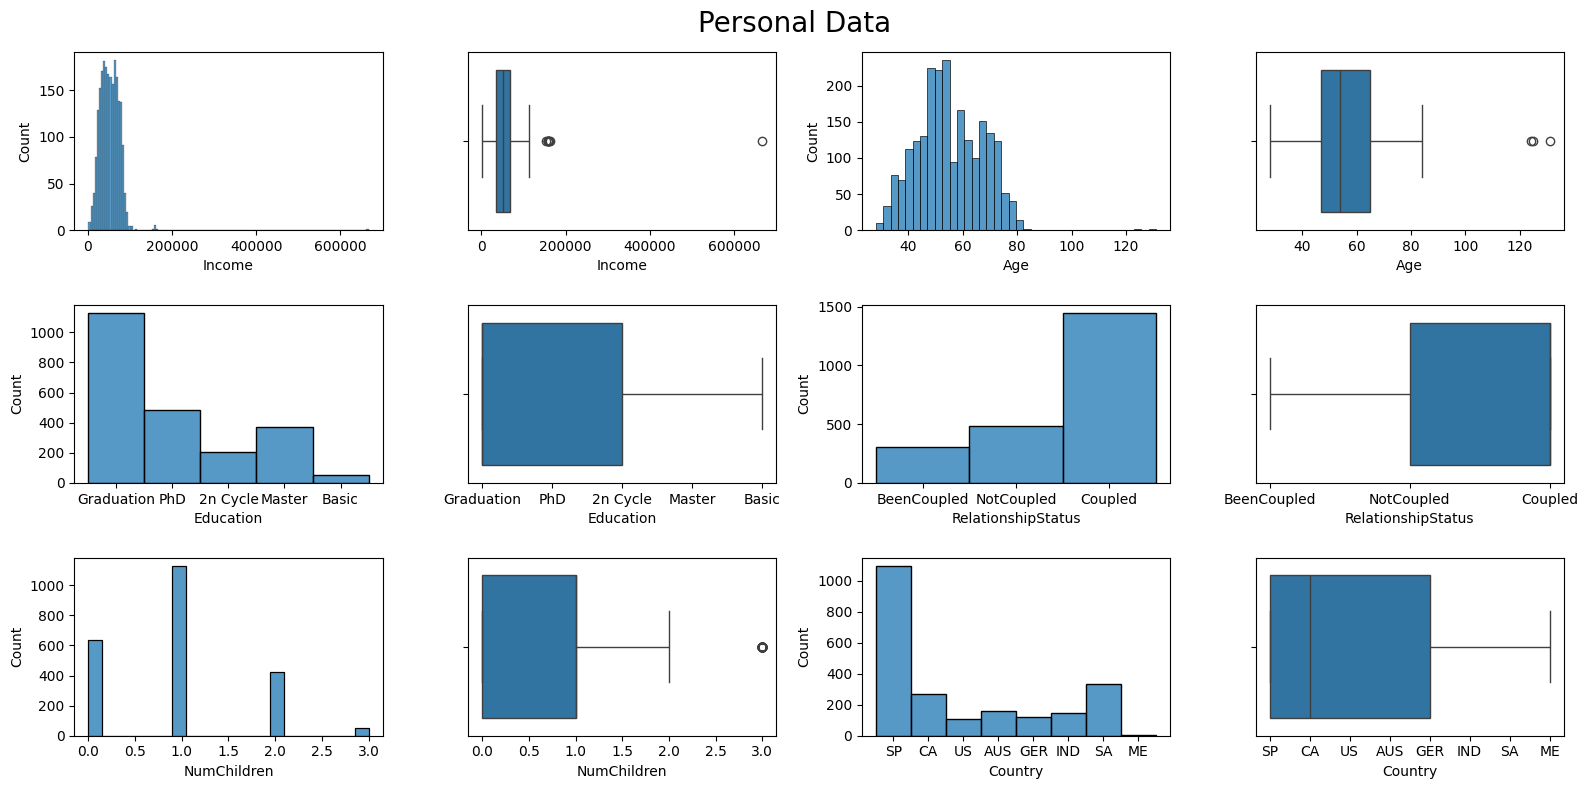

In [2643]:
# Personal Data
# Age, Education, RelationshipStatus, Income, NumChildren, Country

personal_data_columns = [
    "Income",
    "Age",
    "Education",
    "RelationshipStatus",
    "NumChildren",
    "Country",
]
personal_data_title = "Personal Data"
make_distribution_plots(columns=personal_data_columns, title=personal_data_title)

**Outliers and Other Cleanup**

- `Income` and `Age` will need outlier treatment
- We may want to standardize country code to use either 2-letter OR 3-letter, not a mix
- We might consider grouping education levels (e.g. `Basic`, `Moderate`, `High`)

**Initial Observations**

- The majority of most users have some education beyond `Basic`, with `Graduation` the single most frequent amoung education levels
- Most users are from Spain, followed by Saudi Arabia
- Most users have no children or one child


#### "Customer Data" Columns


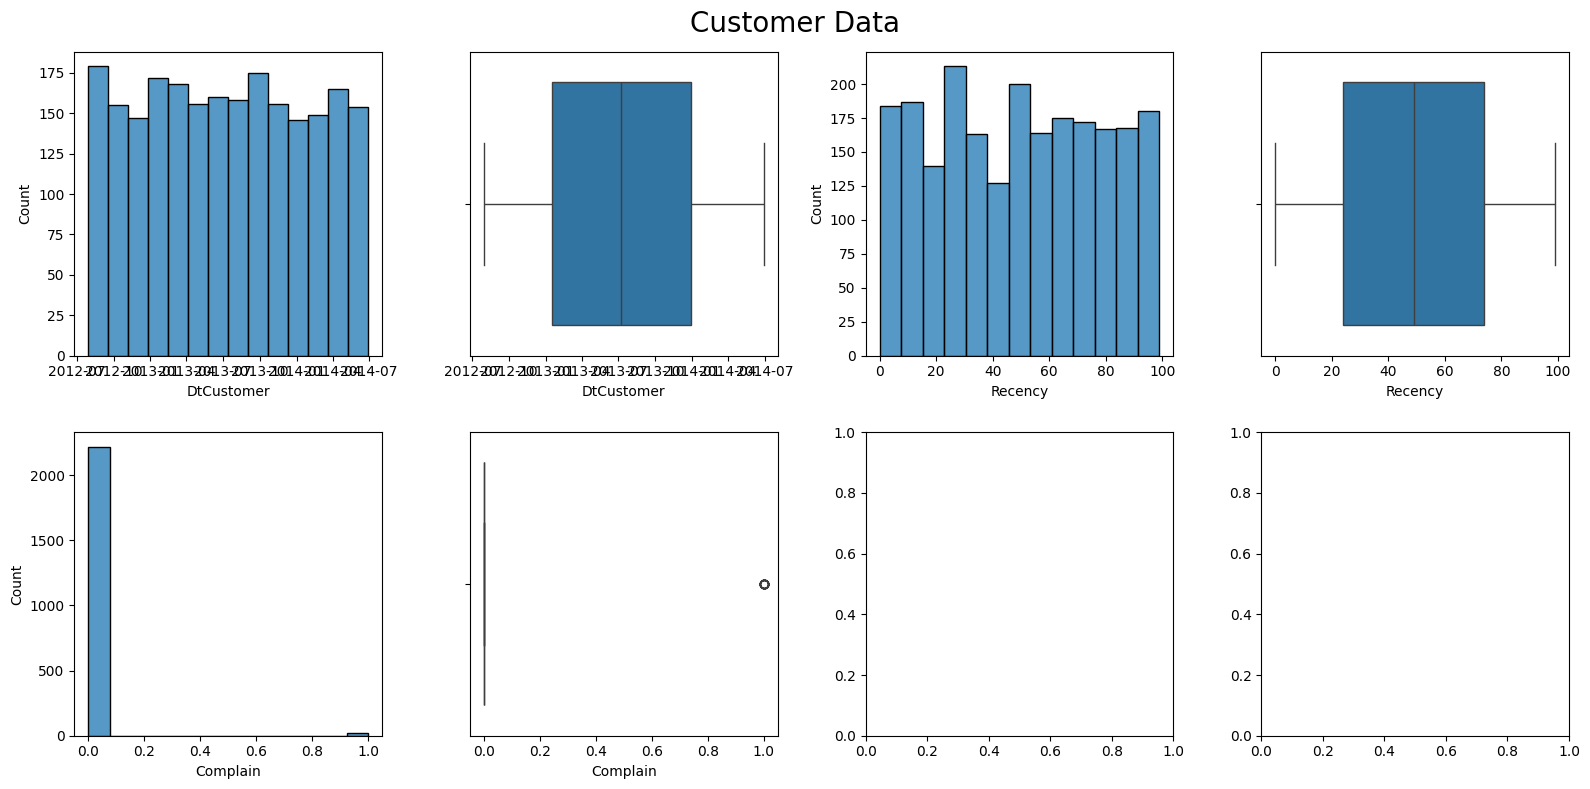

In [2644]:
# Customer Data
# DtCustomer, Recency, Complain
customer_data_columns = ["DtCustomer", "Recency", "Complain"]
make_distribution_plots(columns=customer_data_columns, title="Customer Data")

In [2645]:
df["Complain"].value_counts()

Complain
0    2219
1      21
Name: count, dtype: int64

- No outlier treatment needed here
- 20 customer complaints over the past 2 years


#### "Purchase Data" Columns


##### Products


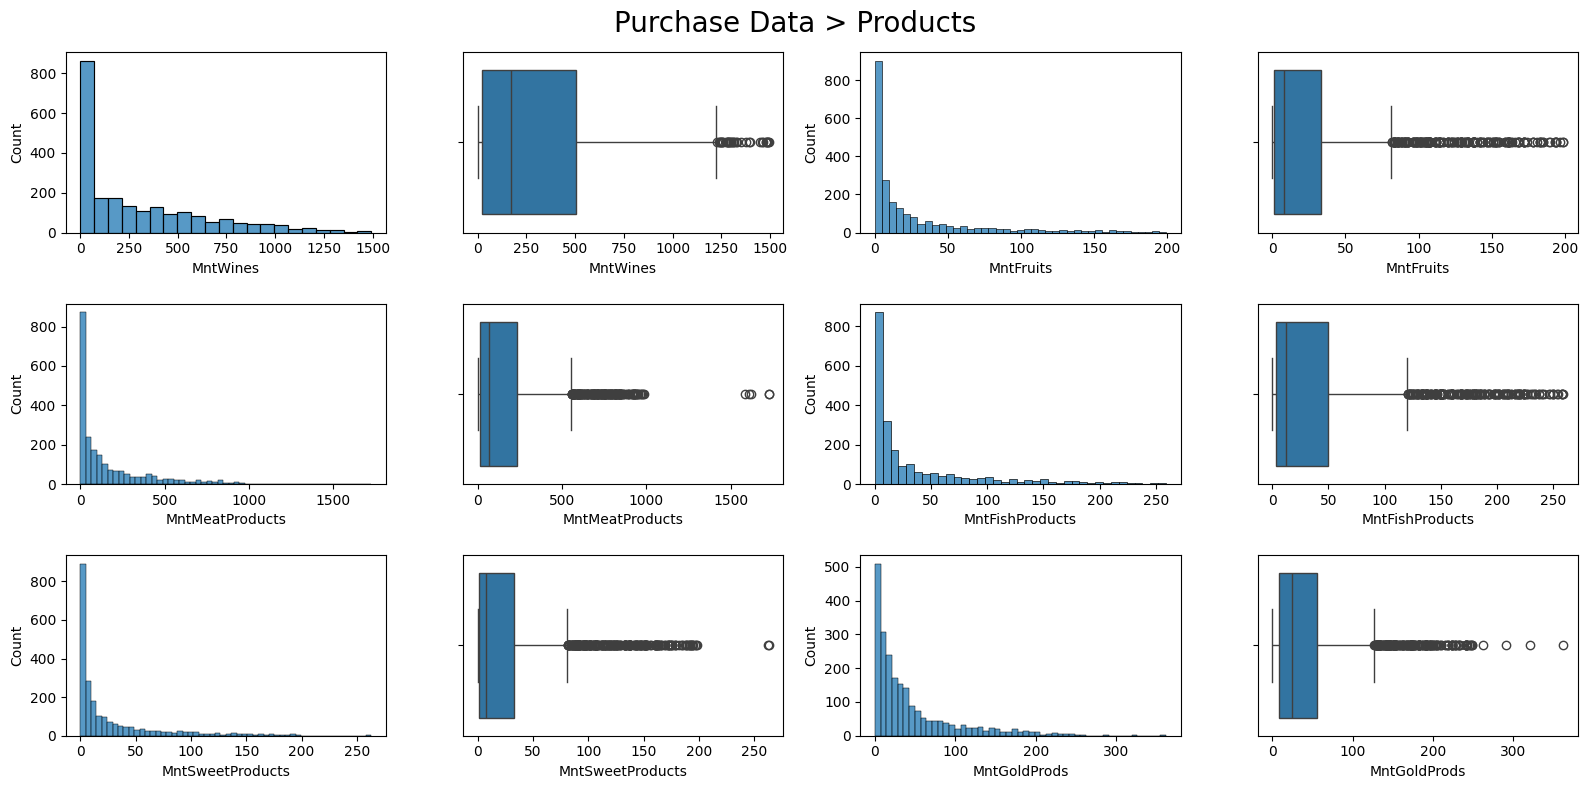

In [2646]:
# Purchase Data > Products
#  MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds

products_columns = [
    "MntWines",
    "MntFruits",
    "MntMeatProducts",
    "MntFishProducts",
    "MntSweetProducts",
    "MntGoldProds",
]
make_distribution_plots(columns=products_columns, title="Purchase Data > Products")

Number of products purchased is positively skewed across all product units


##### Channels


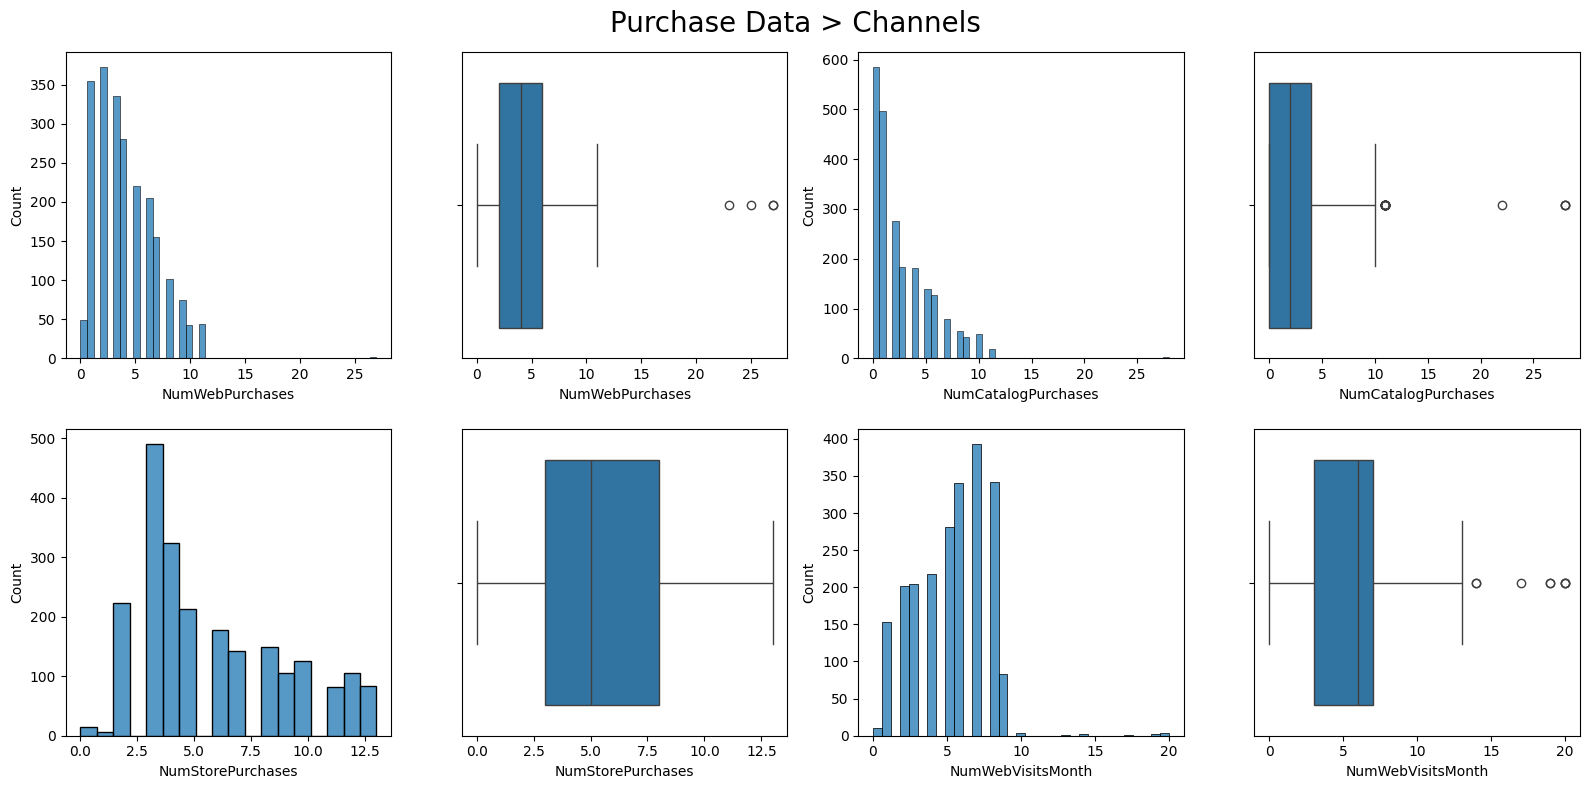

In [2647]:
# Purchase Data > Channels
# NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth

channels_columns = [
    "NumWebPurchases",
    "NumCatalogPurchases",
    "NumStorePurchases",
    "NumWebVisitsMonth",
]
make_distribution_plots(columns=channels_columns, title="Purchase Data > Channels")

- Purchase channels `NumWebPurchases`, `NumCatelogPurchases`, and `NumWebVisitsMonth` are positively skewed and outliers should be trimmed
- `NumStorePurchases` is the least skewed among purchase channels and may not need outlier treatment


##### Offers

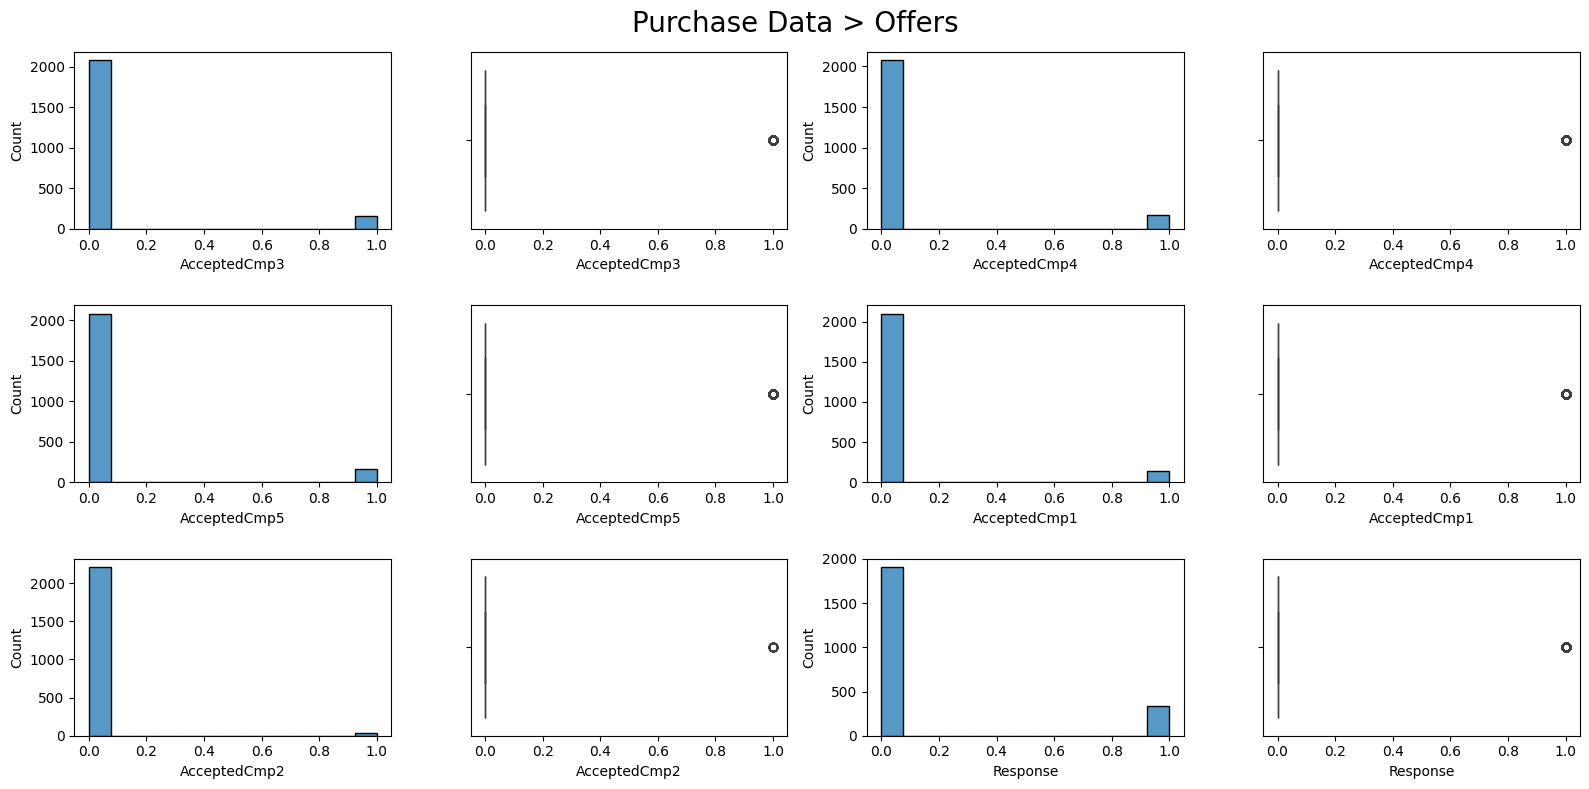

In [2648]:
# Purchase Data > Offers
# NumDealsPurchases, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5, AcceptedCmp1, AcceptedCmp2, Response

offers_columns = [
    # "TotalSpent",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "Response",
]

make_distribution_plots(columns=offers_columns, title="Purchase Data > Offers")

only_offers_columns = df[offers_columns]
accepted_offers = only_offers_columns.loc[(only_offers_columns == 1).any(axis=1)]

## Outlier Treatment


### Definitions

In [2649]:
# For outlier treatment of product columns to help reduce skewness of other columns
prods_lower = 15
prods_upper = 85

### Income


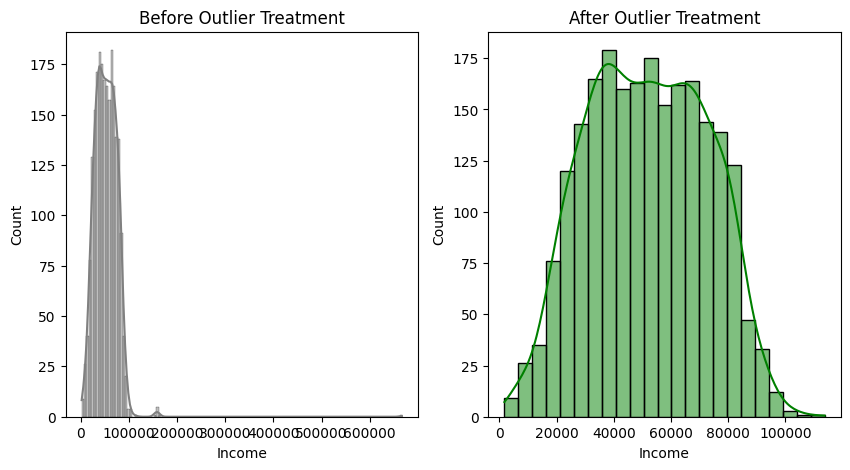

In [2650]:
mask_income, df_income_treated = plot_outlier_treatment("Income")

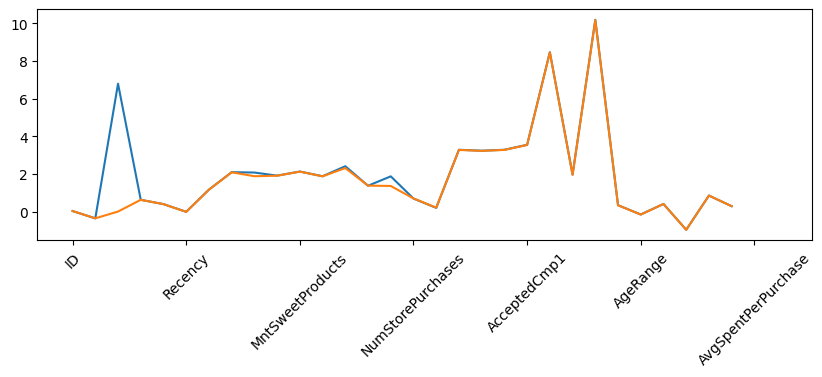

In [2651]:
plot_before_after_skew(df_income_treated)

Income outlier treatment either improves or does not affect skewness of other columns


### Age


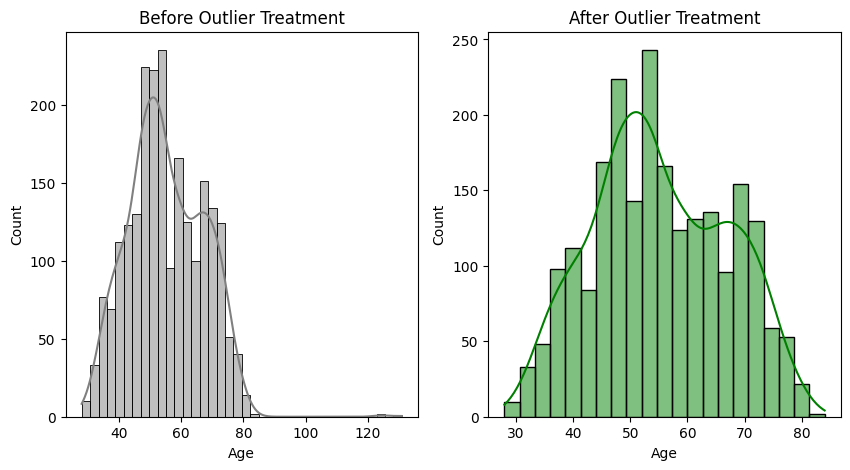

In [2652]:
mask_age, df_age_treated = plot_outlier_treatment("Age")

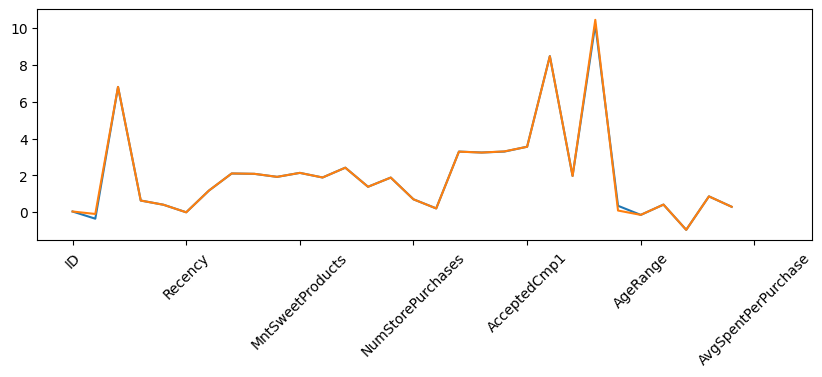

In [2653]:
plot_before_after_skew(df_age_treated)

Outlier treatment for age either improves or does not affect skewness of other columns


### MntWines


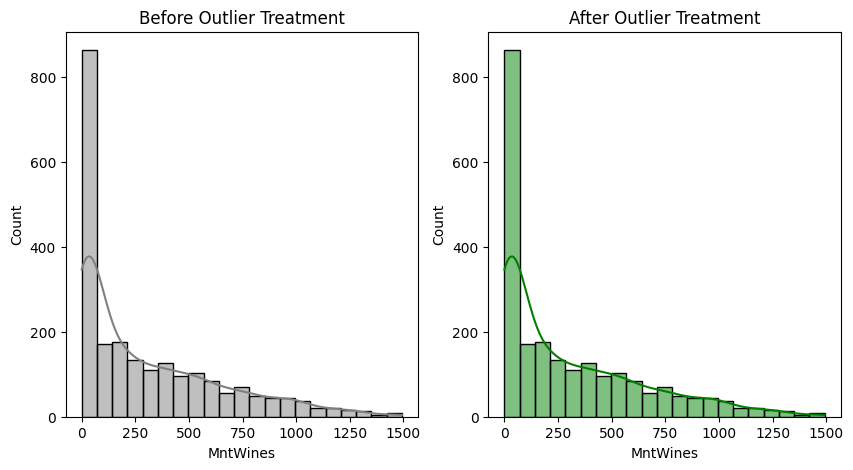

In [2654]:
mask_wines, df_wines_treated = plot_outlier_treatment(
    "MntWines", prods_lower, prods_upper
)

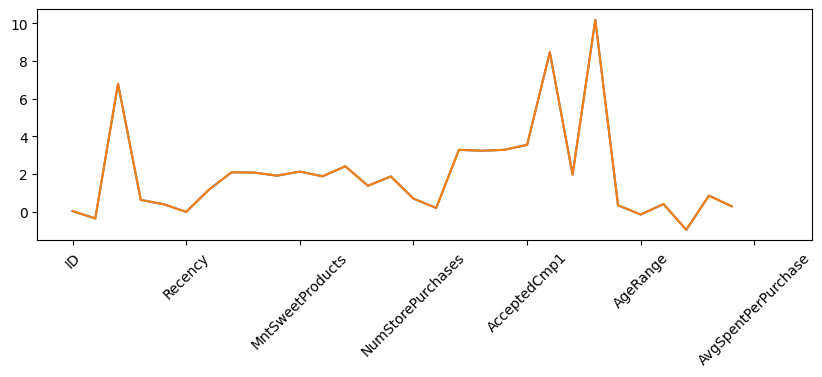

In [2655]:
plot_before_after_skew(df_wines_treated)

### MntFruits


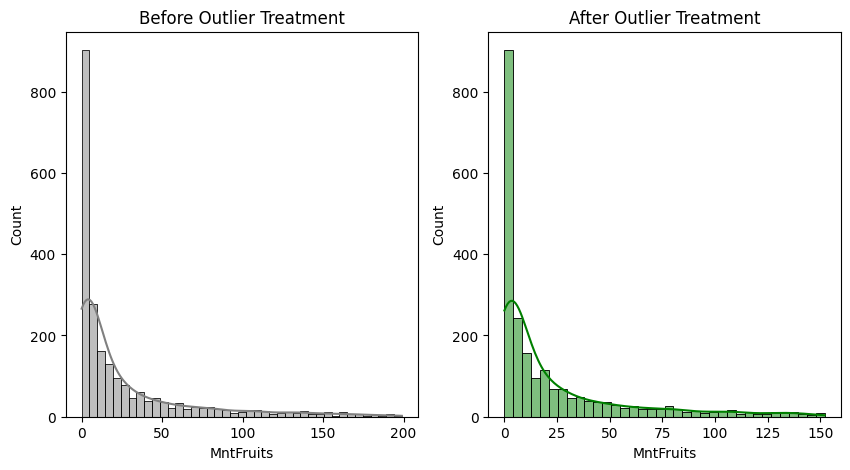

In [2656]:
mask_fruits, df_fruits_treated = plot_outlier_treatment(
    "MntFruits", prods_lower, prods_upper
)

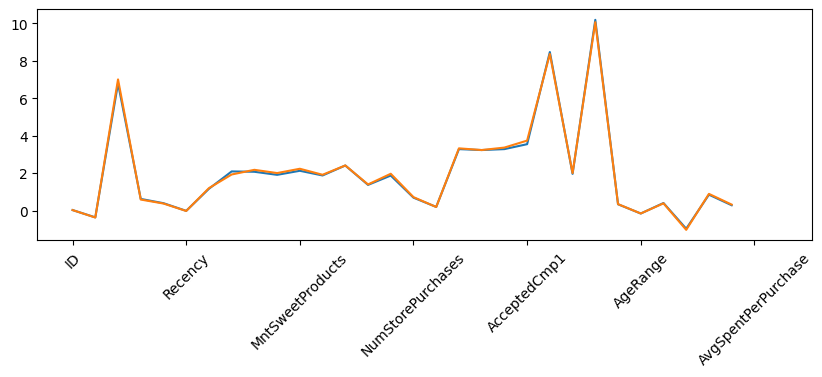

In [2657]:
plot_before_after_skew(df_fruits_treated)

### MntMeatProducts


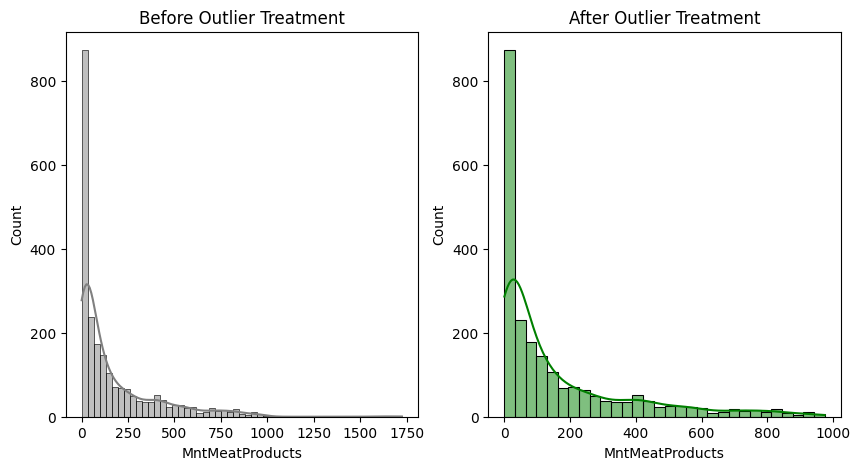

In [2658]:
mask_meats, df_meats_treated = plot_outlier_treatment(
    "MntMeatProducts", prods_lower, prods_upper
)

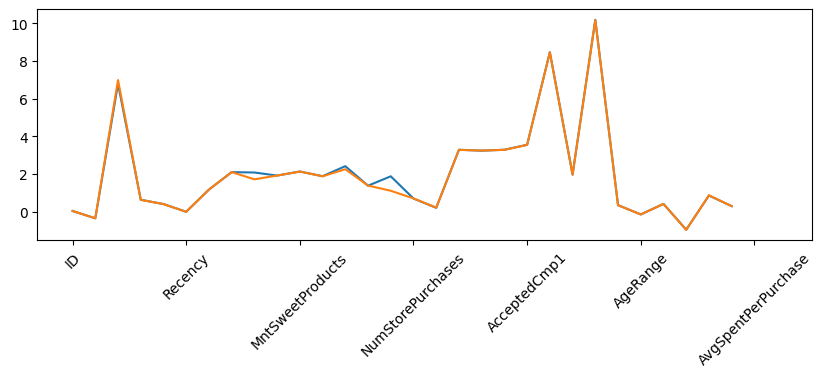

In [2659]:
plot_before_after_skew(df_meats_treated)

### MntFishProducts


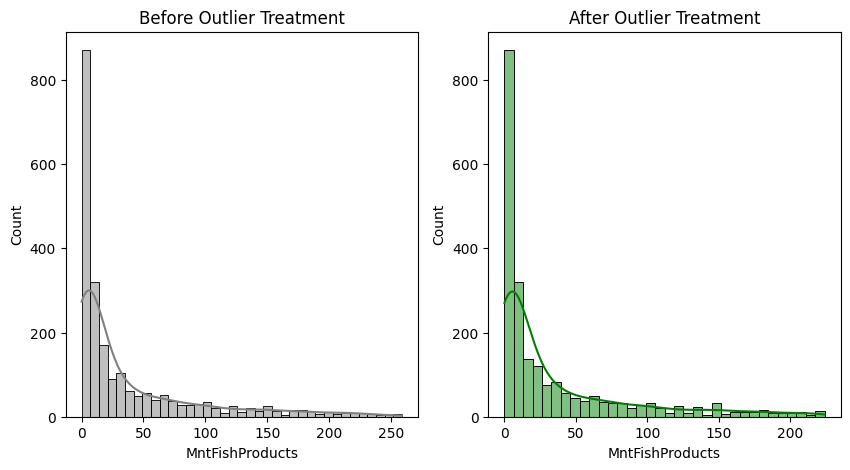

In [2660]:
mask_fish, df_fish_treated = plot_outlier_treatment(
    "MntFishProducts", prods_lower, prods_upper
)

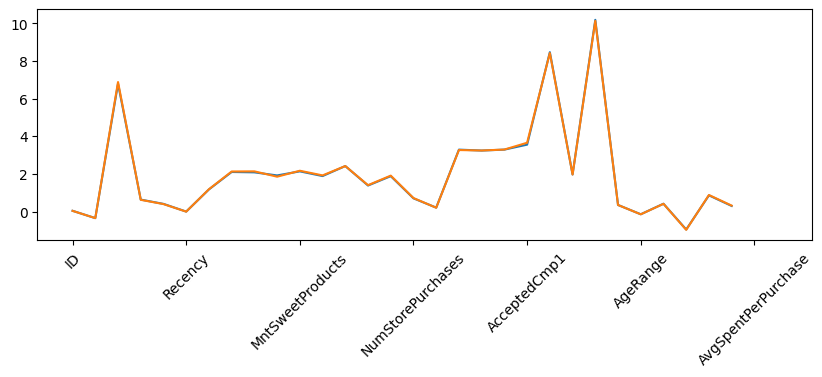

In [2661]:
plot_before_after_skew(df_fish_treated)

### MntSweetProducts


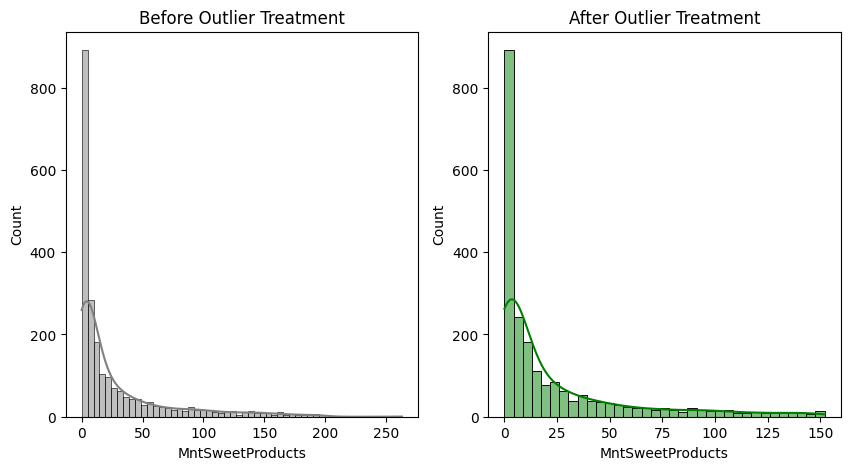

In [2662]:
mask_sweet, df_sweet_treated = plot_outlier_treatment(
    "MntSweetProducts", prods_lower, prods_upper
)

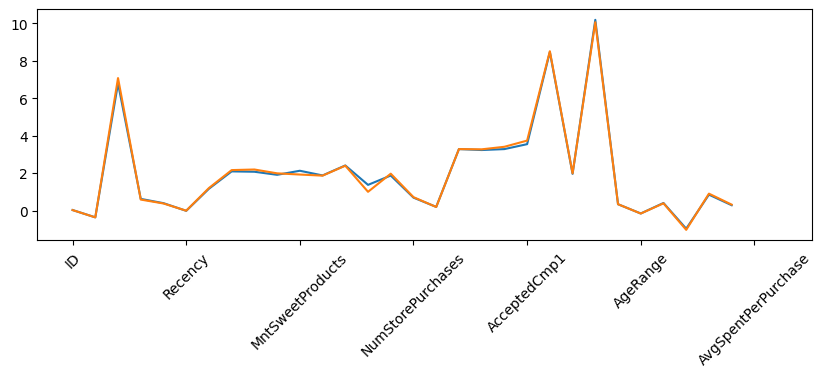

In [2663]:
plot_before_after_skew(df_sweet_treated)

### MntGoldProds


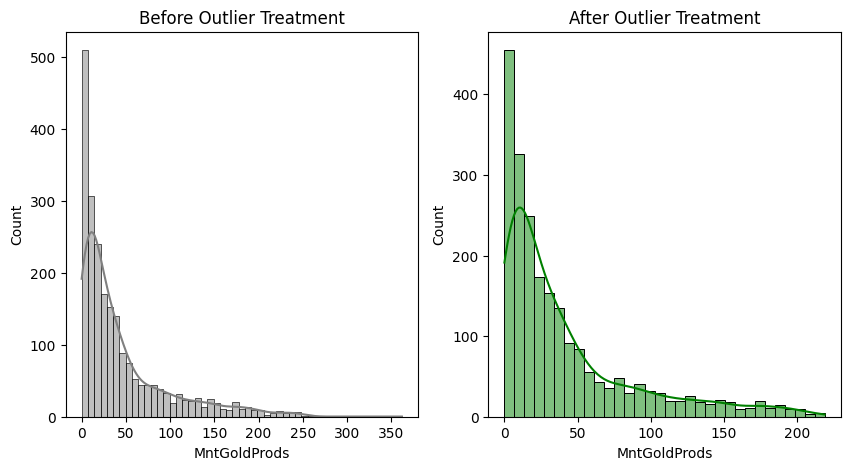

In [2664]:
mask_gold, df_gold_treated = plot_outlier_treatment("MntGoldProds", prods_lower, prods_upper)

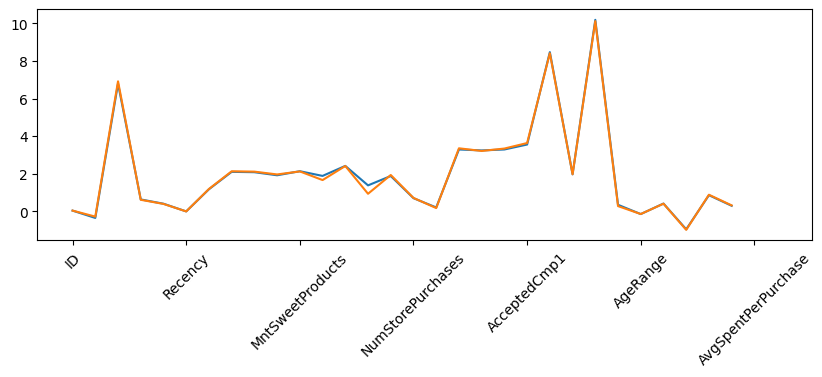

In [2665]:
plot_before_after_skew(df_gold_treated)

### NumWebPurchases


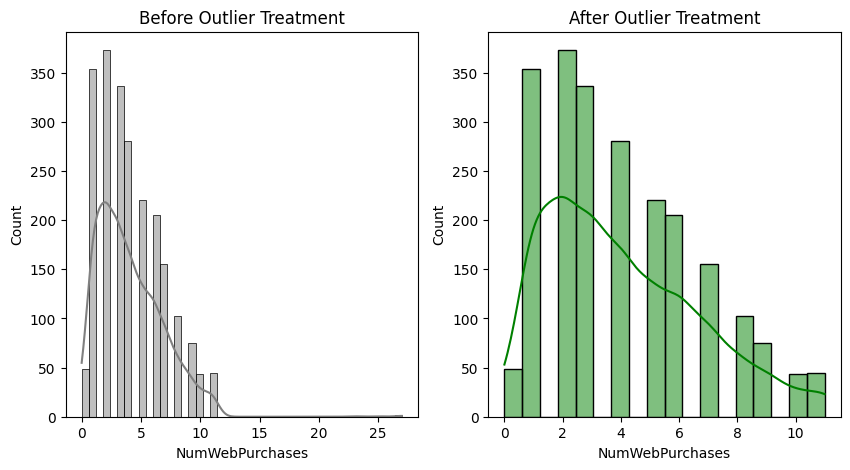

In [2666]:
mask_web_purch, df_web_purch_treated = plot_outlier_treatment("NumWebPurchases")

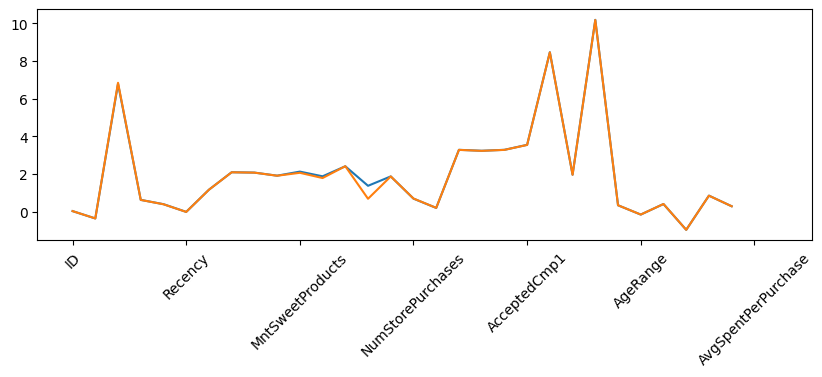

In [2667]:
plot_before_after_skew(df_web_purch_treated)

### NumCatalogPurchases


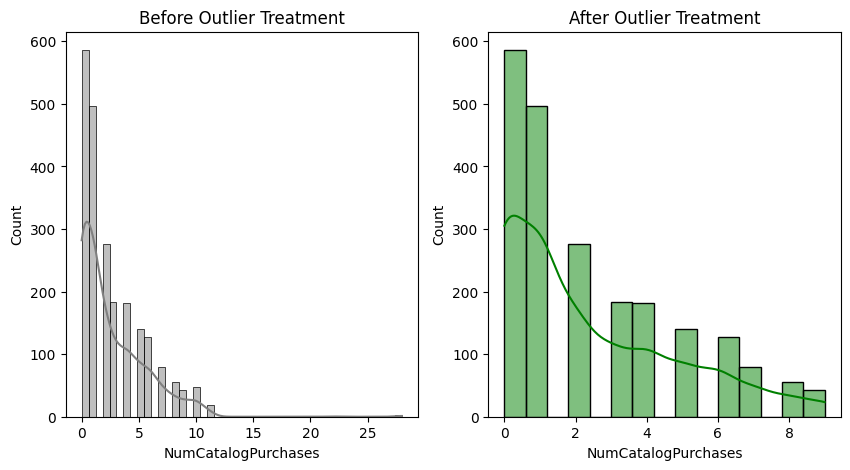

In [2668]:
mask_catalog_purch, df_catalog_purch_treated = plot_outlier_treatment(
    "NumCatalogPurchases"
)

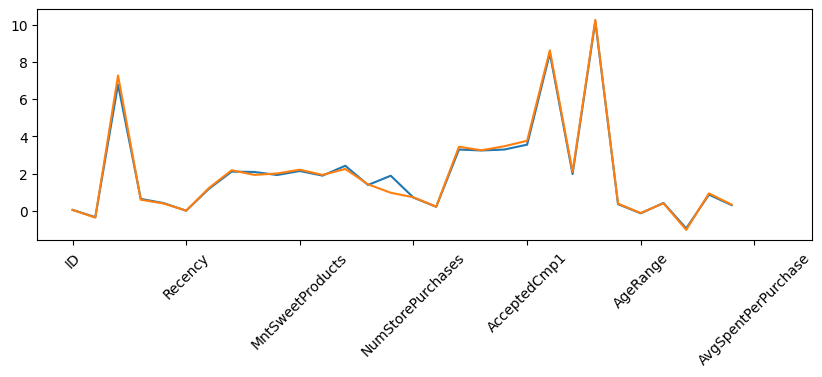

In [2669]:
plot_before_after_skew(df_catalog_purch_treated)

### NumWebVisitsMonth


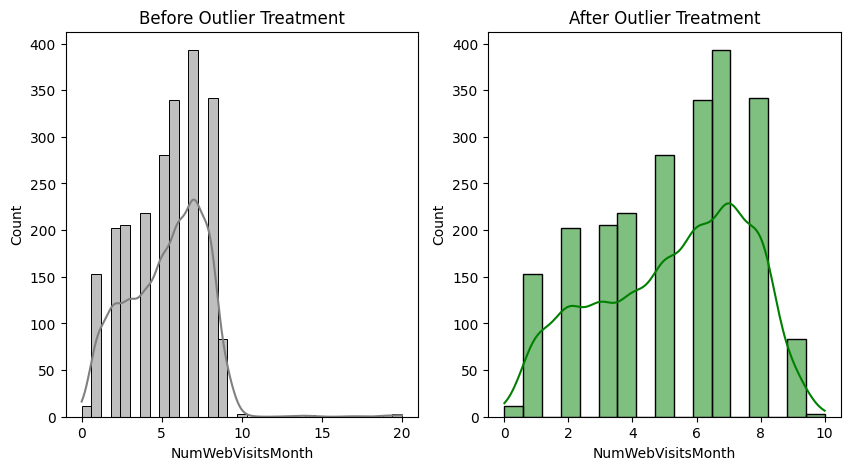

In [2670]:
mask_web_visits, df_web_visits_treated = plot_outlier_treatment("NumWebVisitsMonth")

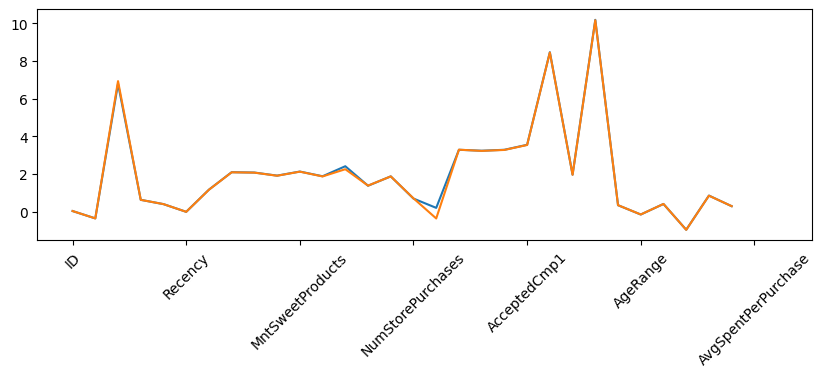

In [2671]:
plot_before_after_skew(df_web_visits_treated)

### TotalSpent


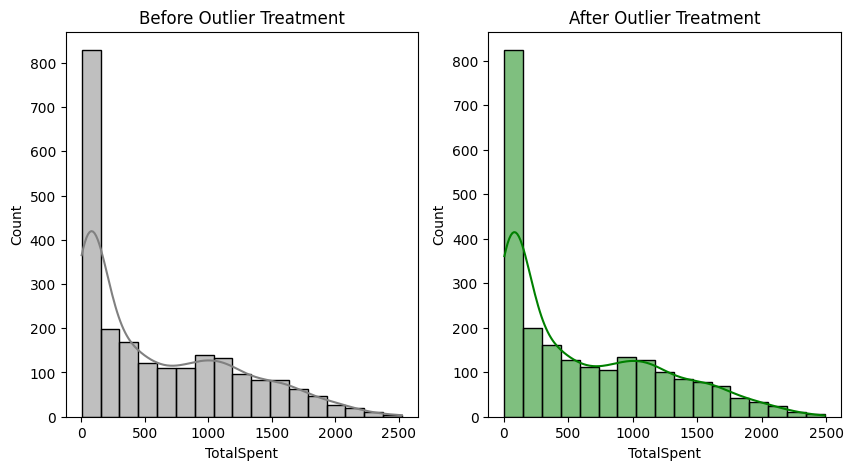

In [2672]:
mask_spent, df_spent_treated = plot_outlier_treatment("TotalSpent")

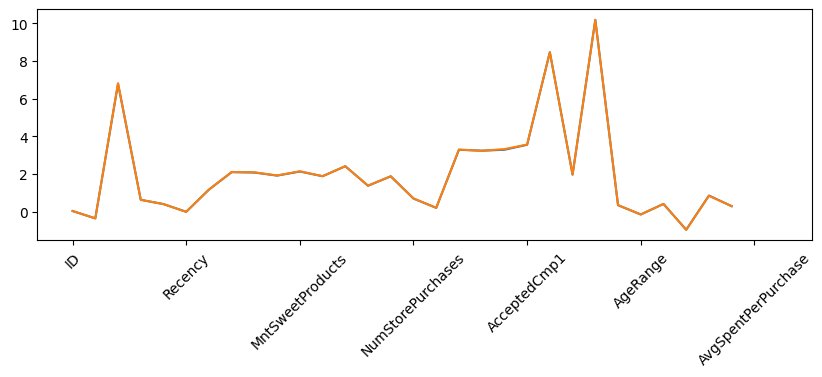

In [2673]:
plot_before_after_skew(df_spent_treated)

### AvgSpentPerPurchase


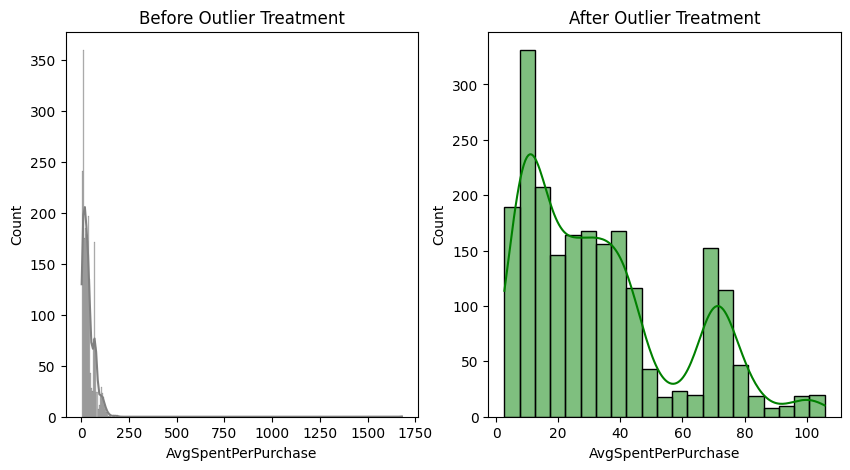

In [2674]:
mask_avg_purch, df_avg_purch_treated = plot_outlier_treatment("AvgSpentPerPurchase")

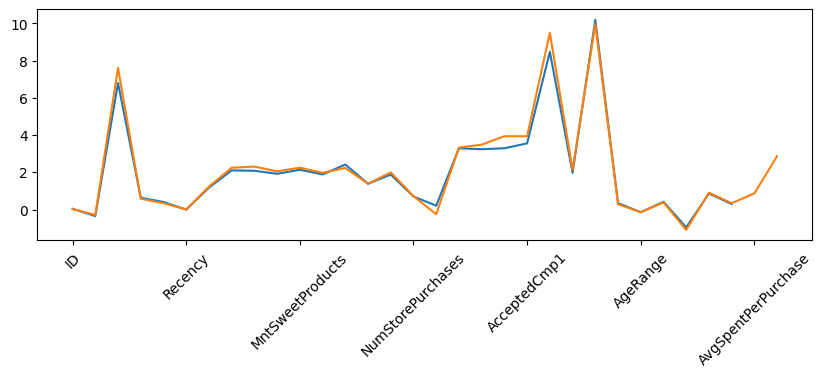

In [2675]:
plot_before_after_skew(df_avg_purch_treated)

### Summary


num rows before: 2240, num rows after: 2095


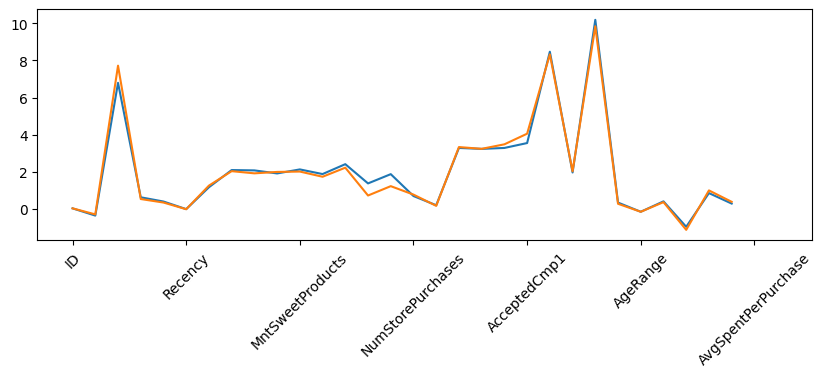

In [2676]:
df_products_outliers_treated = df[
    mask_wines & mask_fruits & mask_meats & mask_fish & mask_sweet & mask_gold
]
print(
    f"num rows before: {df.shape[0]}, num rows after: {df_products_outliers_treated.shape[0]}"
)
plot_before_after_skew(df_products_outliers_treated)

Treating product outliers with the [25,75] IQR function negatively impacted the skewness of other data columns. For that reason, these columns have been trimmed to [15,85] instead, which still improves skewness for product columns

num rows before: 2240, num rows after: 2137


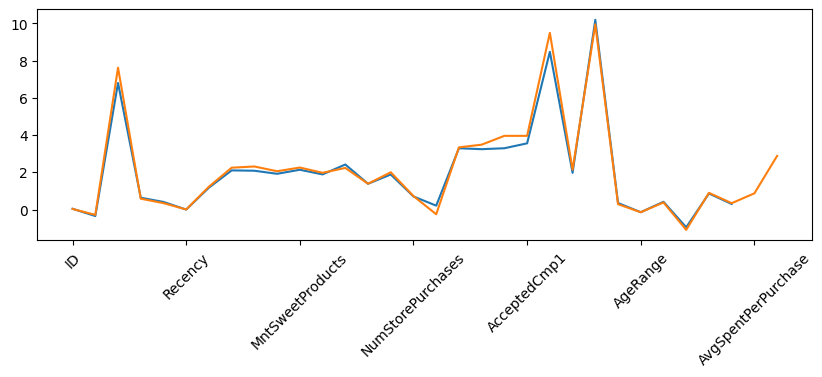

In [2677]:
df_purchase_avg_spent = df[mask_spent & mask_avg_purch]

print(
    f"num rows before: {df.shape[0]}, num rows after: {df_purchase_avg_spent.shape[0]}"
)
plot_before_after_skew(df_purchase_avg_spent)

Treating outliers for `TotalSpent` and `AvgSpentPerPurchase` slightly worsen skew for some other data columns, however, still going to trim outliers for these key columns


num rows before: 2240, num rows after: 1959


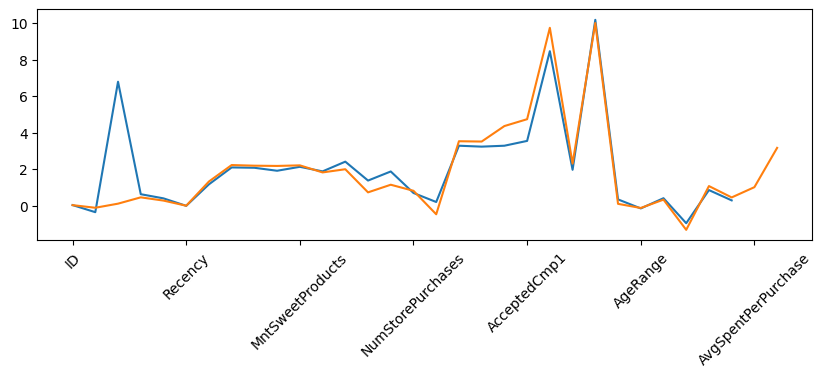

In [2678]:
df_best_outlier_treatment = df[
    mask_age
    & mask_income
    & mask_catalog_purch
    & mask_web_visits
    & mask_web_purch
    & mask_spent
    & mask_avg_purch
    & mask_wines
    & mask_fruits
    & mask_meats
    & mask_fish
    & mask_sweet
    & mask_gold
]
print(
    f"num rows before: {df.shape[0]}, num rows after: {df_best_outlier_treatment.shape[0]}"
)
plot_before_after_skew(df_best_outlier_treatment)

In [2679]:
df = df_best_outlier_treatment

## Encoding

Categorical values that need encoding:

- Education
- RelationshipStatus
- Country


In [2680]:
cat_columns = df.select_dtypes(include=["object"]).columns
# print(cat_columns)

for cat in cat_columns:
    print(df[cat].unique())

# Education
df["EducationNumerical"] = df["Education"].map(
    {"Basic": 0, "Graduation": 1, "2n Cycle": 2, "Master": 3, "PhD": 4}
)

# Country
country = df["Country"]
df = pd.get_dummies(df, dtype=int, columns=["Country"])
df["Country"] = country

# RelationshipStatus
rel_status = df["RelationshipStatus"]
df = pd.get_dummies(df, dtype=int, columns=["RelationshipStatus"])
df["RelationshipStatus"] = rel_status

['Graduation' 'PhD' '2n Cycle' 'Master' 'Basic']
['Single' 'Married' 'Together' 'Widow' 'Divorced' 'YOLO' 'Alone' 'Absurd']
['CA' 'US' 'AUS' 'SP' 'IND' 'SA' 'GER' 'ME']
['NotCoupled' 'Coupled' 'BeenCoupled']


In [2681]:
df.shape

(1959, 49)

## Correlation Heat Maps


### Definitions


In [2682]:
def make_heat_map(column_name, top_num=10):
    top_corrs = (
        df.corr(numeric_only=True).abs().nlargest(top_num, column_name)[column_name]
    )
    print(top_corrs)

    corr_matrix = df[top_corrs.index].corr()

    plt.figure(figsize=(12, 7))
    sns.heatmap(corr_matrix, cmap="viridis", annot=True)
    plt.xticks(rotation=45)

### TotalSpent


TotalSpent             1.000000
AvgSpentPerPurchase    0.949353
MntWines               0.910637
TotalNumPurchases      0.883086
MntMeatProducts        0.849211
NumCatalogPurchases    0.843633
Income                 0.808517
NumStorePurchases      0.781725
NumWebPurchases        0.647146
MntFishProducts        0.628106
Name: TotalSpent, dtype: float64


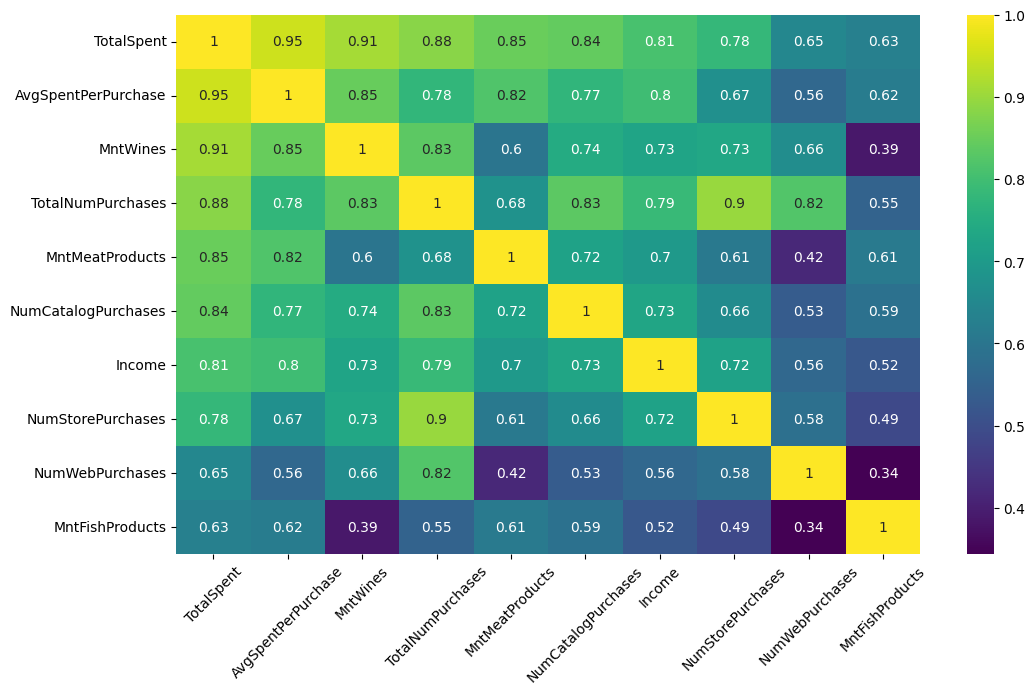

In [2683]:
make_heat_map("TotalSpent")

Wine and meat products have the strongest correlation with total spent amongst product units

### AvgSpentPerPurchase


AvgSpentPerPurchase    1.000000
TotalSpent             0.949353
MntWines               0.848756
MntMeatProducts        0.818856
Income                 0.795171
TotalNumPurchases      0.777081
Name: AvgSpentPerPurchase, dtype: float64


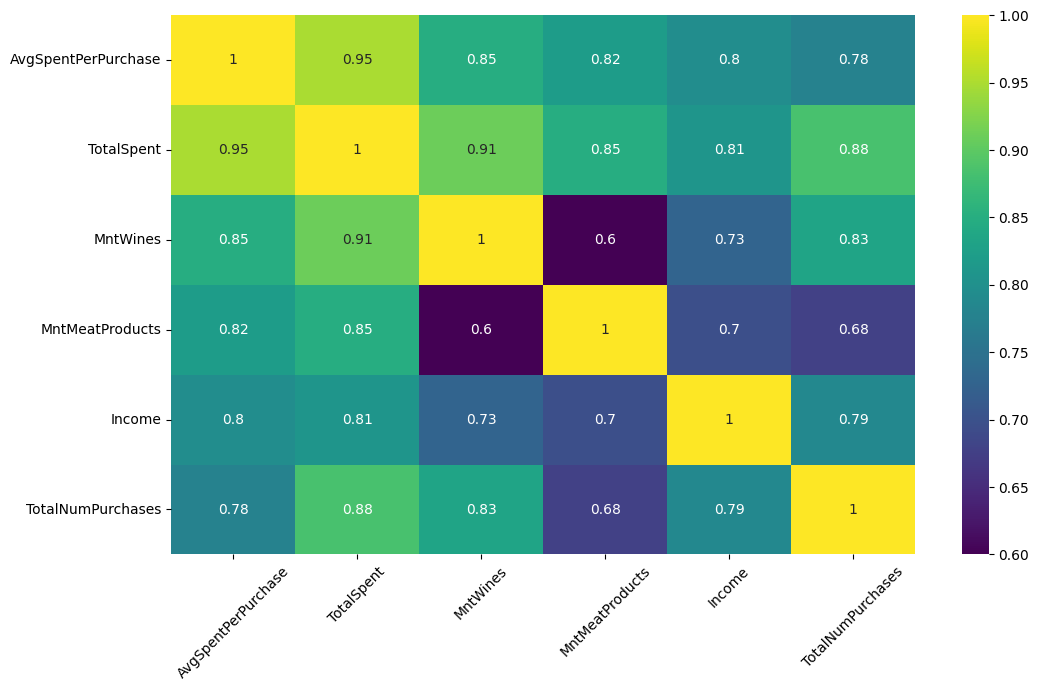

In [2684]:
make_heat_map("AvgSpentPerPurchase", 6)

### AcceptedMultOffers


AcceptedMultOffers    1.000000
Response              0.576452
AcceptedCmp5          0.506753
AcceptedCmp1          0.433994
AcceptedCmp3          0.413602
AcceptedCmp4          0.380520
Name: AcceptedMultOffers, dtype: float64


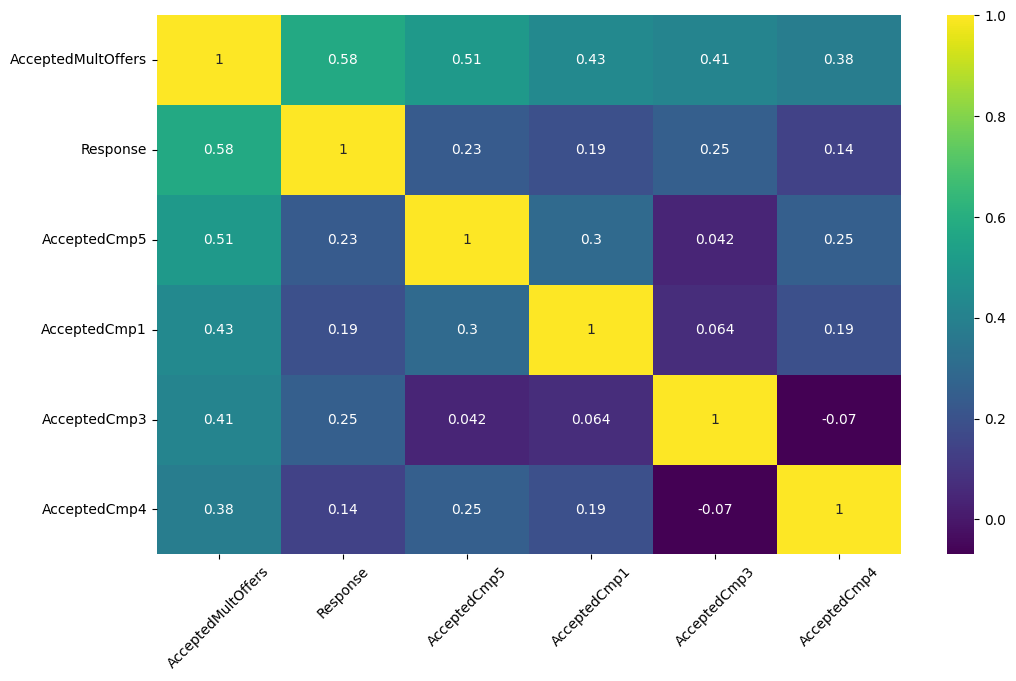

In [2686]:
make_heat_map("AcceptedMultOffers", 6)

Accepting multiple offers is correlated highest with the latest campaign and cmp5

### NumWebPurchases


NumWebPurchases        1.000000
TotalNumPurchases      0.822892
MntWines               0.663067
TotalSpent             0.647146
NumStorePurchases      0.584625
AvgSpentPerPurchase    0.564337
Name: NumWebPurchases, dtype: float64


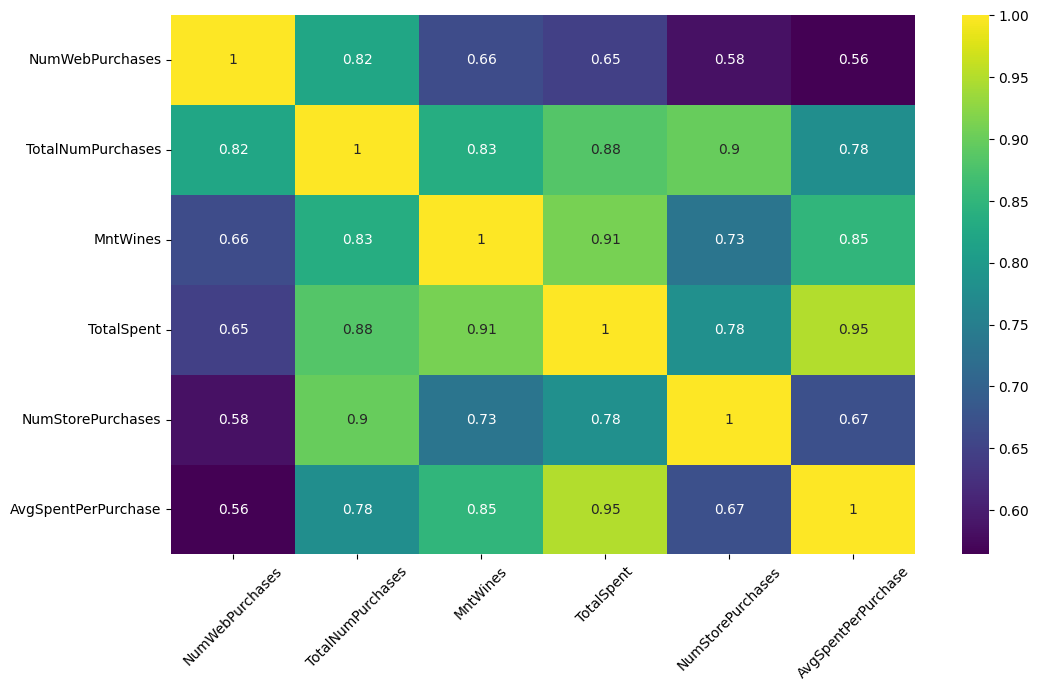

In [2687]:
make_heat_map("NumWebPurchases", 6)

### NumStorePurchases


NumStorePurchases      1.000000
TotalNumPurchases      0.898224
TotalSpent             0.781725
MntWines               0.734092
Income                 0.722070
AvgSpentPerPurchase    0.670118
NumCatalogPurchases    0.657632
MntMeatProducts        0.609313
NumWebPurchases        0.584625
MntFruits              0.521649
Name: NumStorePurchases, dtype: float64


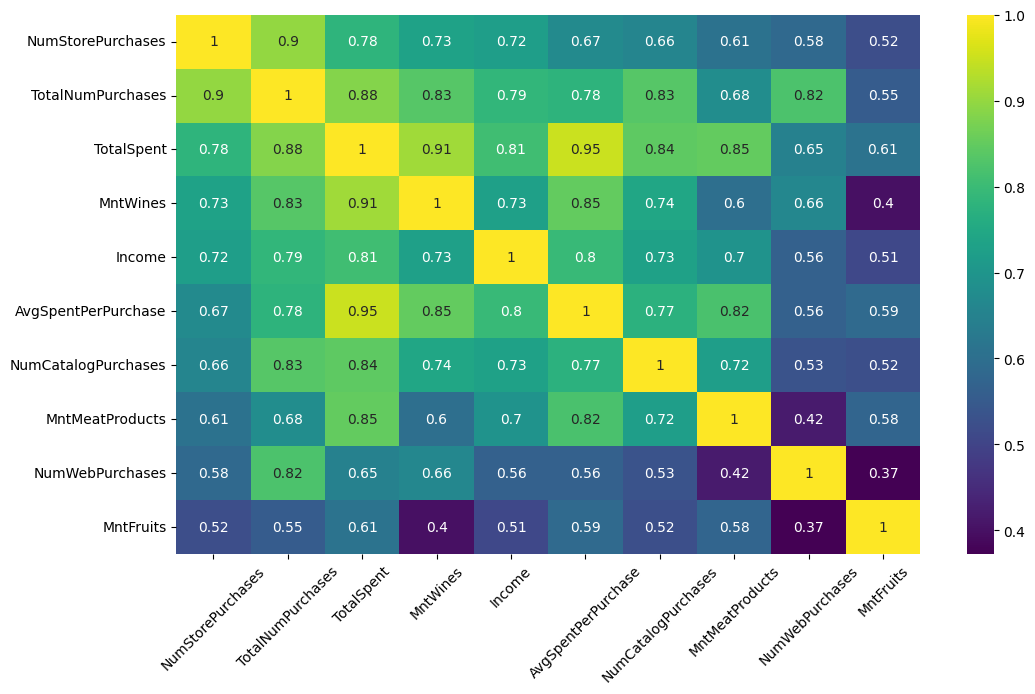

In [2688]:
make_heat_map("NumStorePurchases")

### NumCatalogPurchases


NumCatalogPurchases    1.000000
TotalSpent             0.843633
TotalNumPurchases      0.834305
AvgSpentPerPurchase    0.772906
MntWines               0.744007
Income                 0.730609
MntMeatProducts        0.723081
NumStorePurchases      0.657632
MntFishProducts        0.590041
MntSweetProducts       0.569897
Name: NumCatalogPurchases, dtype: float64


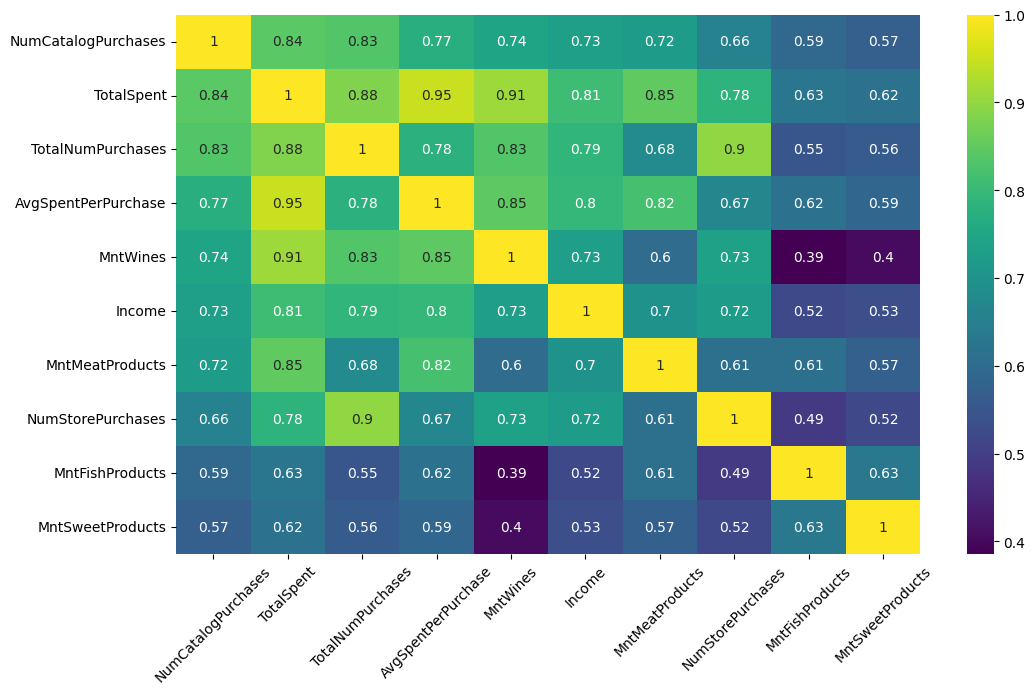

In [2689]:
make_heat_map("NumCatalogPurchases")

# Findings


## Hypothesis Testing


### Definitions


In [2690]:
alpha = 0.05


def stat_eval(p_val, alpha):
    if p_val < alpha:
        print("Reject the null hypothesis")
    else:
        print("Fail to reject the null hypothesis")

### Age + In-Store Shopping


`Null Hypothesis`: For customers aged 65 and older there is no difference in number of purchases online vs. in-store


In [2691]:
df["NumNotInStorePurchases"] = df["NumWebPurchases"] + df["NumCatalogPurchases"]

instore = df[df["Age"] >= 65]["NumStorePurchases"]
online = df[df["Age"] >= 65]["NumWebPurchases"]
# catalog = df[df["Age"] >= 65]["NumCatalogPurchases"]
# not_instore = df[df['Age'] >= 65]['NumNotInStorePurchases']

print(f"online: {online.mean()}, instore: {instore.mean()}")

print("In Store vs. Online")
online_t_stat, online_p_val = sts.ttest_ind(instore, online, alternative="greater")
stat_eval(online_p_val, alpha)

online: 4.553497942386831, instore: 6.345679012345679
In Store vs. Online
Reject the null hypothesis


We are able to reject the null hypothesis and conclude that customers 65 and older are more likely to shop in-store than online.

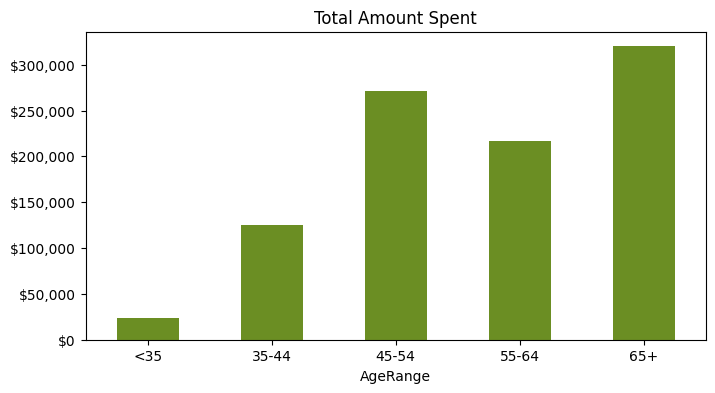

In [2692]:
age_channel_spent = (
    df.groupby("AgeRange")
    .agg({"TotalSpent": "sum"})
    .plot(
        kind="bar",
        legend=False,
        title="Total Amount Spent",
        color="olivedrab",
        figsize=(8, 4),
    )
)
age_channel_spent.axes.xaxis.set_ticks(
    ticks=[0, 1, 2, 3, 4], labels=["<35", "35-44", "45-54", "55-64", "65+"], rotation=0
)
age_channel_spent.yaxis.set_major_formatter(StrMethodFormatter("${x:,.0f}"))

Customers aged `45-54` and `65+` spent the most compared to the other age ranges

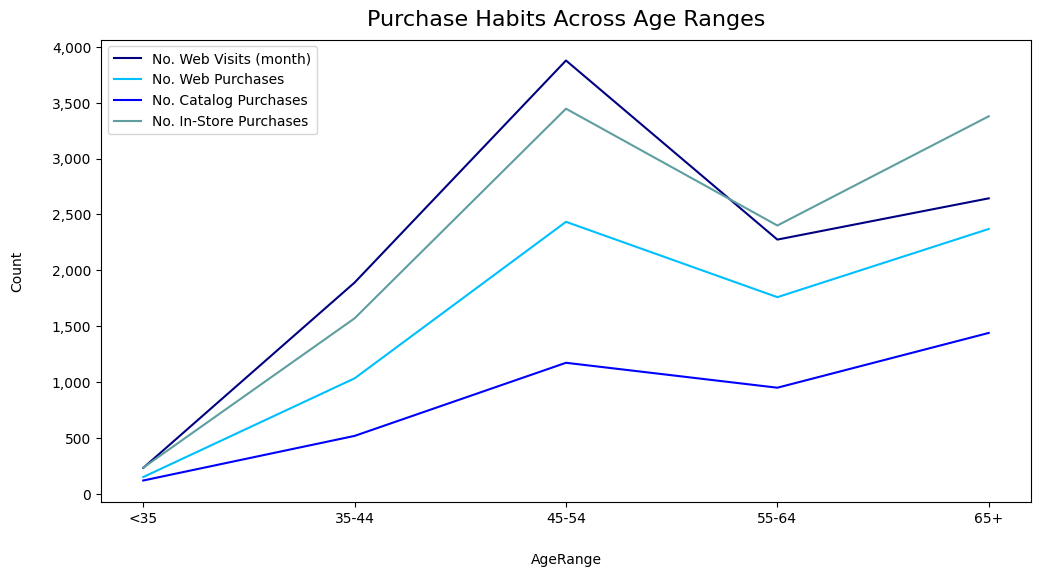

In [2693]:
age_channels_visits = (
    df.groupby("AgeRange")
    .agg(
        {
            "NumWebVisitsMonth": "sum",
            "NumWebPurchases": "sum",
            "NumCatalogPurchases": "sum",
            "NumStorePurchases": "sum",
        }
    )
    .plot(
        figsize=(12, 6),
        ylabel="Count",
        style={
            "NumWebVisitsMonth": "navy",
            "NumWebPurchases": "deepskyblue",
            "NumCatalogPurchases": "blue",
            "NumStorePurchases": "cadetblue",
        },
    )
)

age_channels_visits.axes.xaxis.set_ticks(
    ticks=[0, 1, 2, 3, 4], labels=["<35", "35-44", "45-54", "55-64", "65+"]
)
age_channels_visits.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
age_channels_visits.xaxis.labelpad = 20
age_channels_visits.yaxis.labelpad = 20
age_channels_visits.set_title("Purchase Habits Across Age Ranges", fontsize=16, pad=10)
plt.legend(
    [
        "No. Web Visits (month)",
        "No. Web Purchases",
        "No. Catalog Purchases",
        "No. In-Store Purchases",
    ]
)

- Customers aged `45-54` have the most website visits per month but still spend more in-store than online overall
- Customers aged `65+` have the next highest website visits per month and also spend more in-store than online overall. However, customers aged `65+` have a higher conversion rate (store visits to no. web purchases) than those aged `45-54`
- There may be an opportunity to improve conversion rate and get more online sales from customers aged `45-54`, who are the 2nd highest spenders AND who have the most web visits per month across all age ranges

### Children in home + Online Shopping

`Null Hypothesis`: For customers who have children, there is no significant difference in number of purchases online vs. in-store


In [2694]:
kids_online = df[df["HasChildren"] == True]["NumWebPurchases"]
kids_instore = df[df["HasChildren"] == True]["NumStorePurchases"]
# kids_catalog = df[df["HasChildren"] == True]["NumCatalogPurchases"]
# kids_not_instore = df[df["HasChildren"] == True]["NumNotInStorePurchases"]

print(
    f"Online: {kids_online.mean()}, In-store: {kids_instore.mean()}"
)

print("Online vs. In-Store")
kids_online_t_stat, kids_online_p_val = sts.ttest_ind(
    kids_online, kids_instore, alternative="greater"
)
stat_eval(kids_online_p_val, alpha)

Online: 3.8405797101449277, In-store: 5.13768115942029
Online vs. In-Store
Fail to reject the null hypothesis


We are NOT able to reject the null hypothesis and conclude that customers with children do not purchase more online than in-store.


([<matplotlib.axis.XTick at 0x16cf81870>,
 [Text(0, 0, 'No. Web Visits (month)'),
  Text(1, 0, 'No. Web Purchases'),
  Text(2, 0, 'No. Catalog Purchases'),
  Text(3, 0, 'No. In-Store Purchases')])

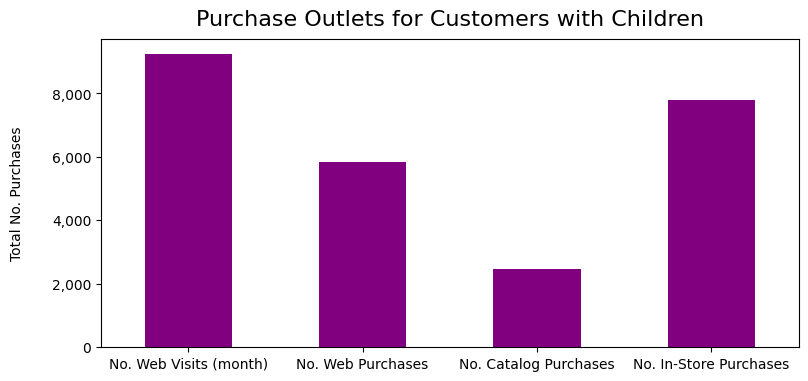

In [2695]:
habits_with_children = (
    df[df["HasChildren"] == True][
        [
            "NumWebVisitsMonth",
            "NumWebPurchases",
            "NumCatalogPurchases",
            "NumStorePurchases",
        ]
    ]
    .sum()
    .plot(
        kind="bar",
        stacked=True,
        figsize=(9, 4),
        ylabel="Total No. Purchases",
        color="purple",
    )
)

habits_with_children.set_title(
    "Purchase Outlets for Customers with Children", fontsize=16, pad=10
)
habits_with_children.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
habits_with_children.xaxis.labelpad = 20
habits_with_children.yaxis.labelpad = 20
plt.xticks(
    ticks=[0, 1, 2, 3],
    labels=[
        "No. Web Visits (month)",
        "No. Web Purchases",
        "No. Catalog Purchases",
        "No. In-Store Purchases",
    ],
    rotation=0,
)

### Online, Catalog Cannibalize In-Store Sales

`Null Hypothesis`: Online + Catalog purchases are not significantly more than Store purchases


In [2696]:
purch_in_store = df["NumStorePurchases"]
purch_not_in_store = df["NumNotInStorePurchases"]

print("Not In-Store vs. In-Store")
purch_channels_t_stat, purch_channels_p_val = sts.ttest_ind(
    purch_in_store, purch_not_in_store, alternative="less"
)
stat_eval(purch_channels_p_val, alpha)

Not In-Store vs. In-Store
Reject the null hypothesis


We are able to reject the null hypothesis and conclude that Online and Catalog purchases are more than In-Store purchases on average.


### US Significantly Better Total Purchases

`Null Hypothesis`: Total purchases in the US is not significantly better than the rest of the world


In [2697]:
purch_us = df[df["Country"] == "US"]["TotalNumPurchases"]
purch_rest = df[df["Country"] != "US"]["TotalNumPurchases"]

purch_us_t_stat, purch_us_p_val = sts.ttest_ind(
    purch_us, purch_rest, alternative="greater"
)
stat_eval(purch_us_p_val, alpha)

Fail to reject the null hypothesis


We fail to reject the null hypothesis and conclude that the US does not fare significantly better than the rest of the world in terms of total purchases


## Visualizations


### Product Performance

**Wine and meat products generated highest revenues**


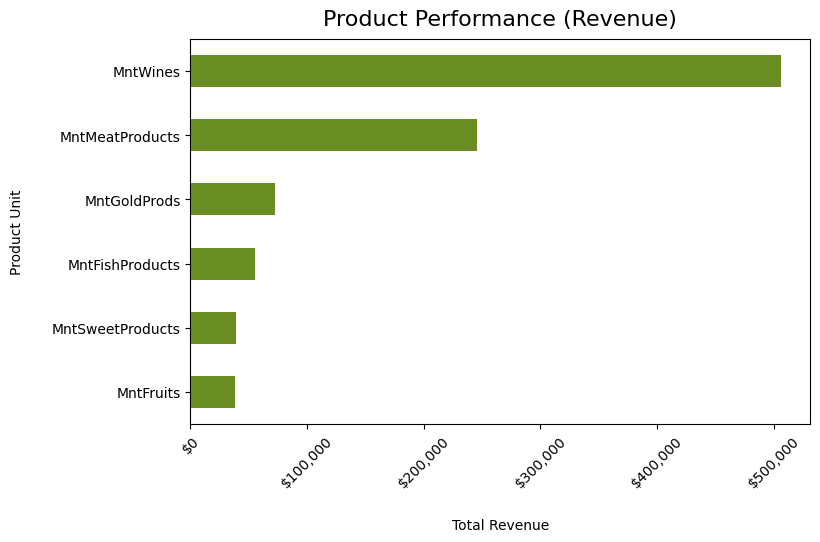

In [2698]:
product_columns = [
    "MntWines",
    "MntFruits",
    "MntMeatProducts",
    "MntFishProducts",
    "MntSweetProducts",
    "MntGoldProds",
]

product_perf = df[product_columns].sum(numeric_only=True).sort_values()
bar = product_perf.plot.barh(
    ylabel="Product Unit",
    xlabel="Total Revenue",
    color="olivedrab",
    figsize=(8, 5),
)
bar.set_title("Product Performance (Revenue)", fontsize=16, pad=10)
plt.xticks(rotation=45)
bar.xaxis.set_major_formatter(StrMethodFormatter("${x:,.0f}"))
bar.xaxis.labelpad = 20
bar.yaxis.labelpad = 20

- **Wines** generated the **most revenue** across product units over the past 2 years
- **Wines** generated nearly twice the revenue of the next-largest product unit, **Meat Products**
- **Sweet Products** and **Fruits** generated the least revenue over the same period


### Age + Last Campaign Acceptance Rate

- **Customers aged 35-44 had the highest acceptance rate of the latest campaign**
- **The latest campaign had a higher acceptance rather across almost all age ranges than any other campaign**


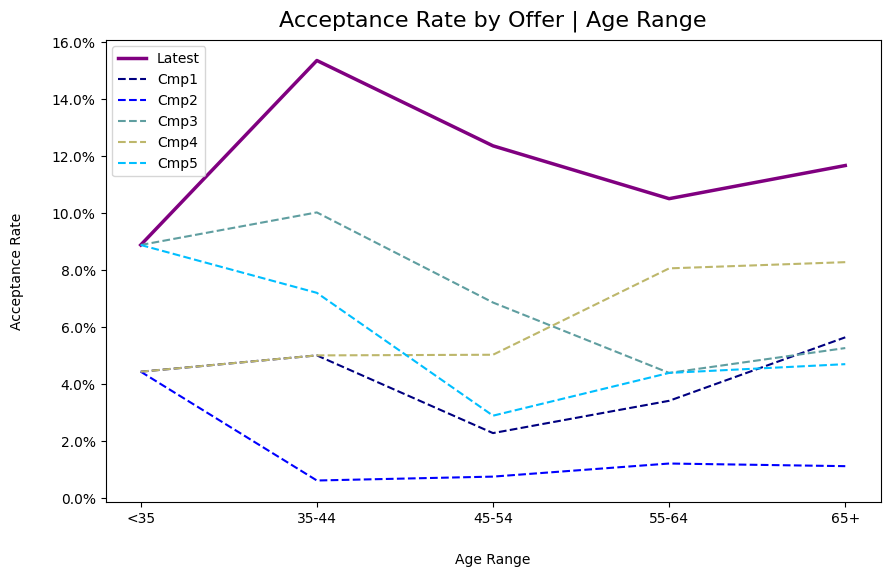

In [2699]:
accepted_last = df[df["Response"] == 1]["Response"]
num_accept = sum(df["Response"])
accept_rate = num_accept / len(df)

line_chart = (
    df.groupby("AgeRange")
    .agg(
        {
            "Response": "mean",
            "AcceptedCmp1": "mean",
            "AcceptedCmp2": "mean",
            "AcceptedCmp3": "mean",
            "AcceptedCmp4": "mean",
            "AcceptedCmp5": "mean",
        }
    )
    .plot(
        style={
            "Response": "purple",
            "AcceptedCmp1": "navy",
            "AcceptedCmp2": "blue",
            "AcceptedCmp3": "cadetblue",
            "AcceptedCmp4": "darkkhaki",
            "AcceptedCmp5": "deepskyblue",
        },
        ylabel="Acceptance Rate",
        xlabel="Age Range",
        figsize=(10, 6),
    )
)

for index, line in enumerate(line_chart.get_lines()):
    if index == 0:
        line.set_linewidth(2.5)
    else:
        line.set_linestyle("--")

line_chart.set_title("Acceptance Rate by Offer | Age Range", pad=10, fontsize=16)
line_chart.yaxis.set_major_formatter(PercentFormatter(1.0))
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=["<35", "35-44", "45-54", "55-64", "65+"])
plt.legend(["Latest", "Cmp1", "Cmp2", "Cmp3", "Cmp4", "Cmp5"])
line_chart.xaxis.labelpad = 20
line_chart.yaxis.labelpad = 20

- Customers in the `35-44` age range accepted the latest offer at the **highest rate** compared to the other age ranges
- Customers aged `65+` accepted the latest offer at the **2nd-highest rate**
- Customers in the `<35` and `55-64` age ranges accepted the latest offer at the **lowest rates**
- That latest offer's acceptance rate was higher across almost all age ranges than any of the previous offers
- `Cmp2` had the lowest acceptance rate across all age ranges compared to the other offers


### Last Offer Acceptance per Country

- **Spain had the most customers who accepted the latest offer**
- **Spain, Saudia Arabia, and Germany had the highest acceptance rates**


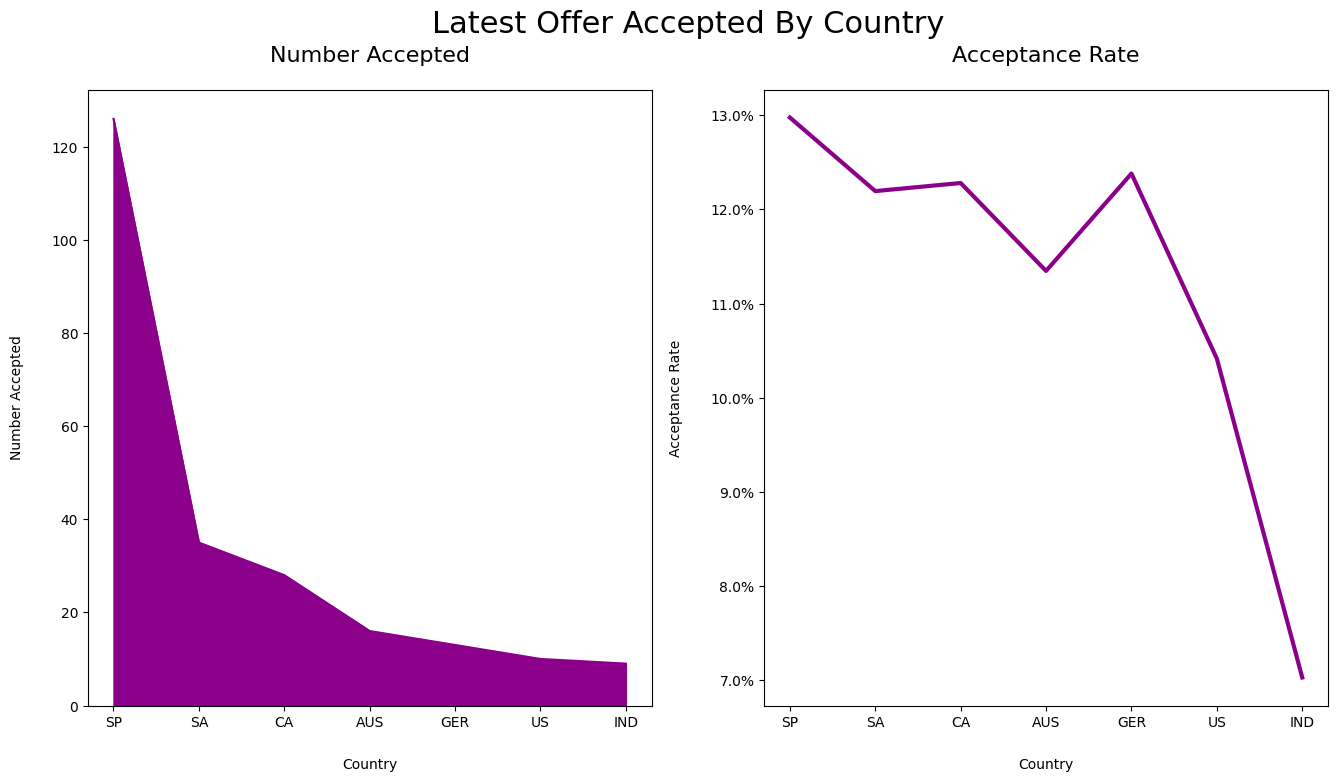

In [2700]:
area_fig, area_axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
area_fig.suptitle("Latest Offer Accepted By Country", fontsize=22)

accepted_last = df[(df["Response"] == 1) & (df['Country'] != "ME")]
area_count = (
    accepted_last["Country"]
    .value_counts()
    .plot(kind="area", color="darkmagenta", ylabel="Number Accepted", ax=area_axes[0])
)

area_count.set_title("Number Accepted", pad=20, fontsize=16)
area_count.xaxis.labelpad = 20
area_count.yaxis.labelpad = 20

count_order = pd.Series(accepted_last["Country"].value_counts().keys())
count_order_dictionary = {}
for index, country in enumerate(count_order):
    count_order_dictionary[country] = index

area_rate = (
    df.groupby(df[df['Country'] != 'ME']["Country"])
    .agg({"Response": "mean"})
    .sort_values(by="Country", key=lambda x: x.map(count_order_dictionary))
    .plot(
        ax=area_axes[1],
        ylabel="Acceptance Rate",
        color="darkmagenta",
        linewidth=3,
        legend=False,
    )
)
area_rate.yaxis.set_major_formatter(PercentFormatter(1.0))
area_rate.set_title("Acceptance Rate", pad=20, fontsize=16)
area_rate.xaxis.labelpad = 20
area_rate.yaxis.labelpad = 20

(_Note that Montenegro (ME) has been trimmed from these charts due to low number of cases (3)_)

- Spain (SP) had the most customers who accepted the latest offer among countries
- Spain (SP) also had the most total customers by a wide margin
- Spain (SP), Saudi Arabia (SA), and Germany (GER) had the highest acceptance rates among other countries 


### Education + Complaints

**Complaints highest amongst customers with Graduation-level of education**


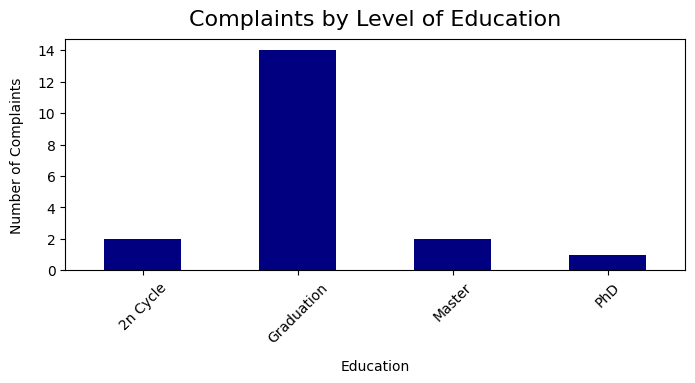

In [2701]:
df_complaints = df[df["Complain"] == 1]
complaints_cross = pd.crosstab(
    df_complaints["Education"], df_complaints["Complain"]
).plot(
    kind="bar",
    figsize=(8, 3),
    color="navy",
    legend=False,
    ylabel="Number of Complaints",
)

plt.xticks(rotation=45)
complaints_cross.set_title("Complaints by Level of Education", pad=10, fontsize=16)
complaints_cross.xaxis.labelpad = 10
complaints_cross.yaxis.labelpad = 10

### Spending Habits + No. Children

- **Households with one child spent the most**
- **Households with no children had the highest median spending**


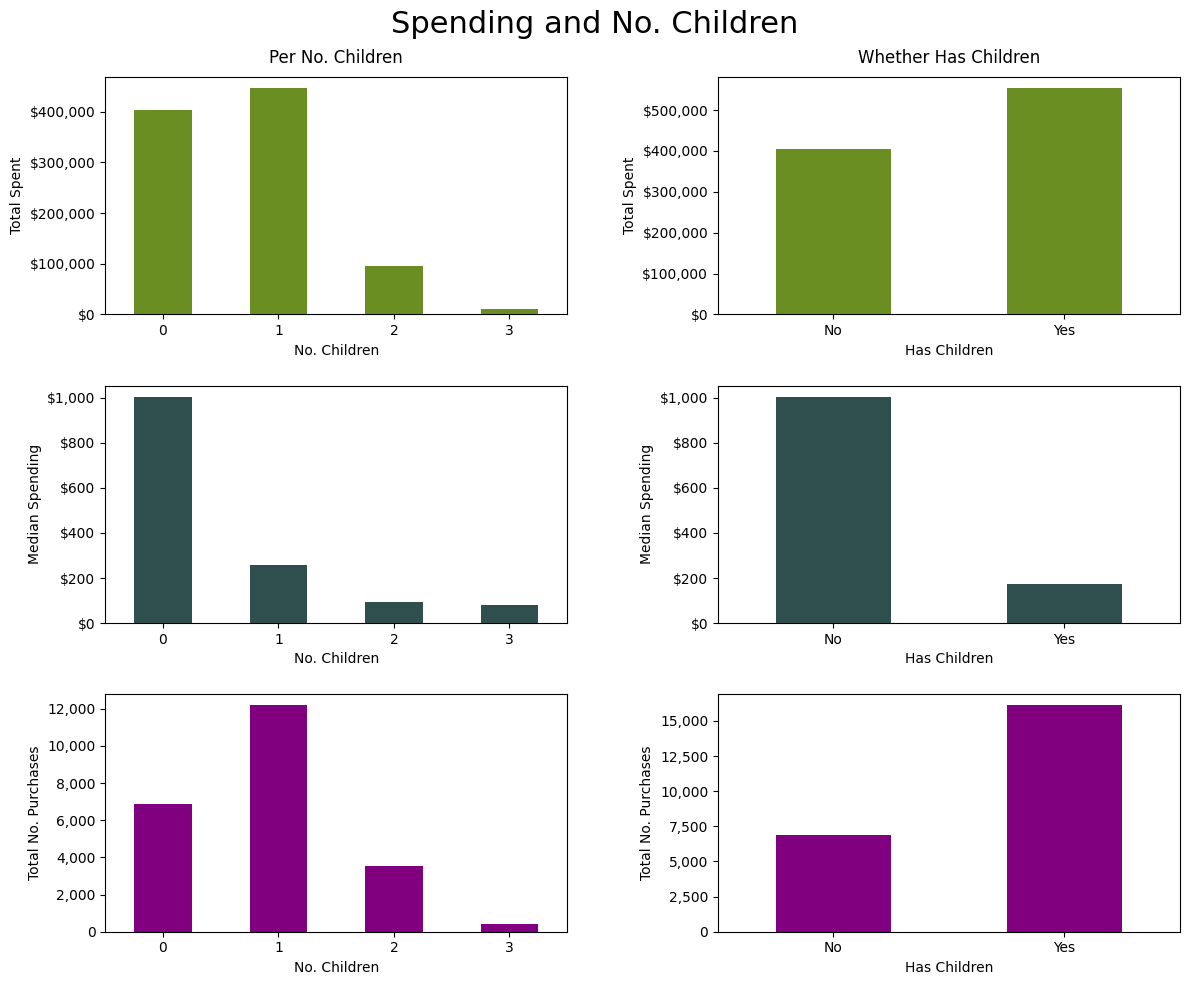

In [2702]:
bar_fig, bar_axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
bar_fig.suptitle("Spending and No. Children", fontsize=22)

bar_num_kids_spent = (
    df.groupby("NumChildren")
    .agg({"TotalSpent": "sum"})
    .plot(
        kind="bar",
        color="olivedrab",
        xlabel="No. Children",
        ylabel="Total Spent",
        legend=False,
        ax=bar_axes[0, 0],
    )
)

bar_has_kids_spent = (
    df.groupby("HasChildren")
    .agg({"TotalSpent": "sum"})
    .plot(
        kind="bar",
        color="olivedrab",
        xlabel="Has Children",
        ylabel="Total Spent",
        legend=False,
        ax=bar_axes[0, 1],
    )
)

bar_num_kids_med = (
    df.groupby("NumChildren")
    .agg({"TotalSpent": "median"})
    .plot(
        kind="bar",
        color="darkslategrey",
        xlabel="No. Children",
        ylabel="Median Spending",
        legend=False,
        ax=bar_axes[1, 0],
    )
)

bar_has_kids_med = (
    df.groupby("HasChildren")
    .agg({"TotalSpent": "median"})
    .plot(
        kind="bar",
        color="darkslategrey",
        xlabel="Has Children",
        ylabel="Median Spending",
        legend=False,
        ax=bar_axes[1, 1],
    )
)

bar_num_kids_purch = (
    df.groupby("NumChildren")
    .agg({"TotalNumPurchases": "sum"})
    .plot(
        kind="bar",
        color="purple",
        xlabel="No. Children",
        ylabel="Total No. Purchases",
        legend=False,
        ax=bar_axes[2, 0],
    )
)

bar_has_kids_purch = (
    df.groupby("HasChildren")
    .agg({"TotalNumPurchases": "sum"})
    .plot(
        kind="bar",
        color="purple",
        xlabel="Has Children",
        ylabel="Total No. Purchases",
        legend=False,
        ax=bar_axes[2, 1],
    )
)

bar_has_kids_spent.set_xticks(ticks=[False, True], labels=["No", "Yes"], rotation=0)
bar_has_kids_spent.set_title("Whether Has Children", pad=10)
bar_has_kids_spent.yaxis.set_major_formatter(StrMethodFormatter("${x:,.0f}"))
bar_has_kids_med.set_xticks(ticks=[False, True], labels=["No", "Yes"], rotation=0)
bar_has_kids_med.yaxis.set_major_formatter(StrMethodFormatter("${x:,.0f}"))
bar_has_kids_purch.set_xticks(ticks=[False, True], labels=["No", "Yes"], rotation=0)
bar_has_kids_purch.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))

bar_num_kids_spent.set_xticks(ticks=[0, 1, 2, 3], labels=[0, 1, 2, 3], rotation=0)
bar_num_kids_spent.set_title("Per No. Children", pad=10)
bar_num_kids_spent.yaxis.set_major_formatter(StrMethodFormatter("${x:,.0f}"))
bar_num_kids_med.set_xticks(ticks=[0, 1, 2, 3], labels=[0, 1, 2, 3], rotation=0)
bar_num_kids_med.yaxis.set_major_formatter(StrMethodFormatter("${x:,.0f}"))
bar_num_kids_purch.set_xticks(ticks=[0, 1, 2, 3], labels=[0, 1, 2, 3], rotation=0)
bar_num_kids_purch.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))

plt.tight_layout(w_pad=4, h_pad=2)

- Households with no children or one child outspent those with two or more children by a wide margin
- Total spent and total number of purchases were both highest in households with one child
- Customers with (any number of) children spent more in total than those without children
- Median spending was higher for households without children. Total number of purchases were higher for households with children. These suggest that customers without children tend to spend more on average and per purchase

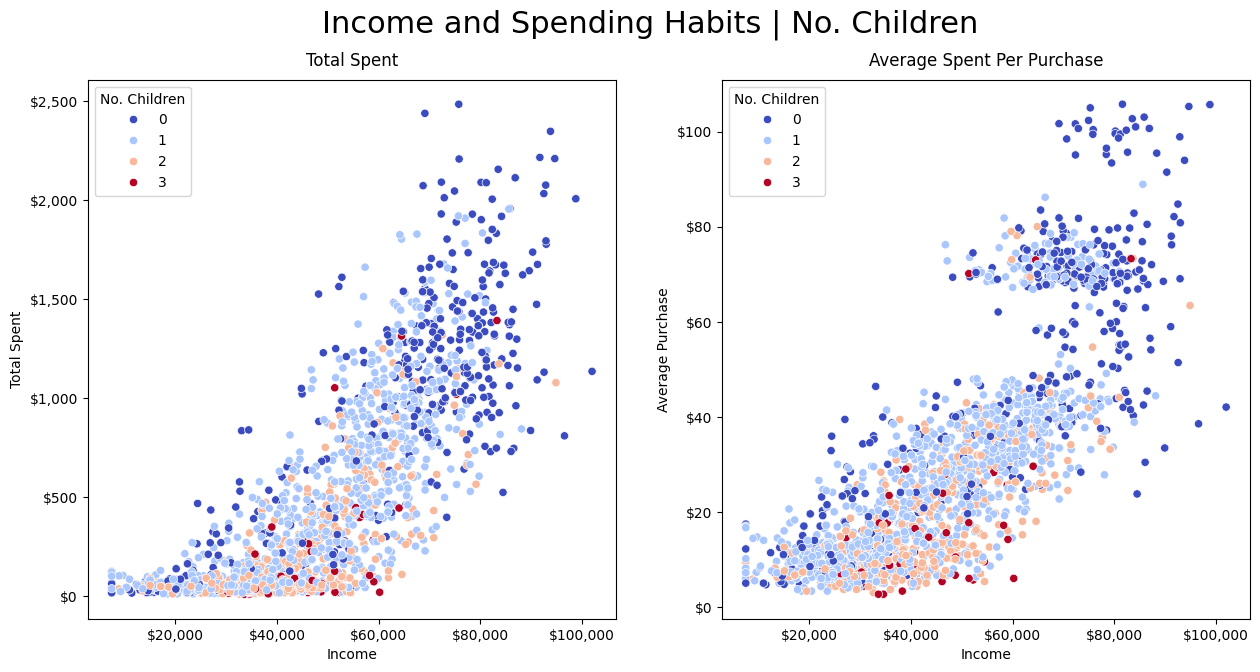

In [2703]:
scatter_kids_fig, scatter_kids_axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
scatter_kids_fig.suptitle("Income and Spending Habits | No. Children", fontsize=22)

kids_total_spent = sns.scatterplot(
    data=df,
    x="Income",
    y="TotalSpent",
    palette="coolwarm",
    hue="NumChildren",
    ax=scatter_kids_axes[0],
)

kids_avg_spent = sns.scatterplot(
    data=df,
    x="Income",
    y="AvgSpentPerPurchase",
    palette="coolwarm",
    hue="NumChildren",
    ax=scatter_kids_axes[1],
)

kids_total_spent.set_title("Total Spent", pad=10)
kids_total_spent.set_ylabel("Total Spent")
kids_total_spent.xaxis.set_major_formatter(StrMethodFormatter("${x:,.0f}"))
kids_total_spent.yaxis.set_major_formatter(StrMethodFormatter("${x:,.0f}"))
kids_total_spent.legend(title="No. Children")

kids_avg_spent.set_title("Average Spent Per Purchase", pad=10)
kids_avg_spent.set_ylabel("Average Purchase")
kids_avg_spent.xaxis.set_major_formatter(StrMethodFormatter("${x:,.0f}"))
kids_avg_spent.yaxis.set_major_formatter(StrMethodFormatter("${x:,.0f}"))
kids_avg_spent.legend(title="No. Children")

- Customers without children tend to make more and spend more than those with children
- Even as spending increases as income increases, customers with no children or one child tend to spend more than those with two or more children in the similar income brackets
